### Team O 
- Sohyeong KIM 
- Mathieu LAMIOT
- Xingce BAO
- Milica NOVAKOVIC

date : 31.05.2018

## This is the main code for this project 

There are some other source codes that are written along with this project. 

One is to train a model that can detect the numbers on the pieces. After training, we imported the trained model and use it to detect numbers. These functions are ``mnist_training.py``, ``data_augument.py ``, ``model.py``. 

The other is the file that is containing related functions that we are using in this project. The detail of each functions are written in the file ``utils.py``

In [1]:
import numpy as np
import cv2 as cv
from skimage import morphology
from scipy.ndimage.morphology import binary_fill_holes
from scipy.linalg import norm
import math
import scipy
import glob
from scipy import linalg
import imutils
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline


# Import our function library and model
from utils import *     
import model
test_model = model.Model('model.ckpt')

Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Restoring parameters from model.ckpt
model loaded.


## Import the images from the CAM

In [2]:
from iapr.webcam import WebcamVideoStream

# Create Webcam instance
wvs = WebcamVideoStream(src=0)

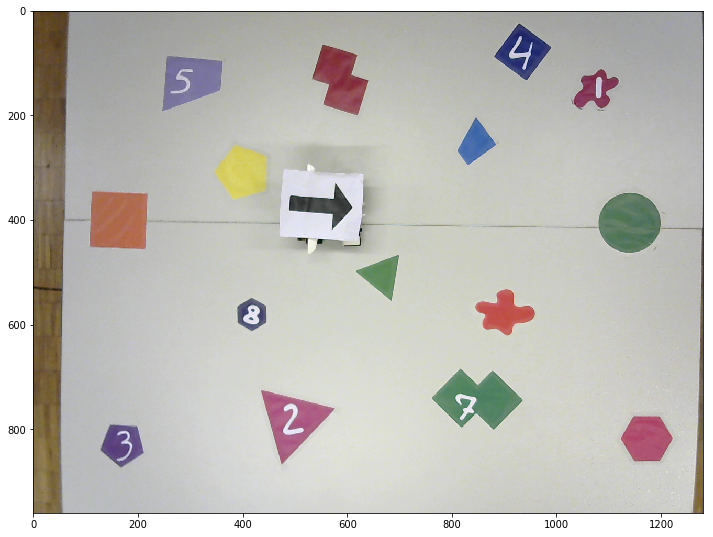

In [3]:
# Read most recent frame
image = wvs.read()

# Show the image read
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(image, cmap='gray' )

## Part1. Object Detection and Matching

Our method:

    1. Preprossed the input image and detect the objects.
    2. Separte the objects into holes and pieces. 
    3. If objects are pieces, recognize the numbers written on them.
    4. Detect the circle and remove it from the list of objects while storing its position separately.
    5. For every pieces, find the matching holes. 
    6. Create a dictionary of the position of every objects.  
  

### 1. Preprossed the input image and detect the objects

188.73673095703126


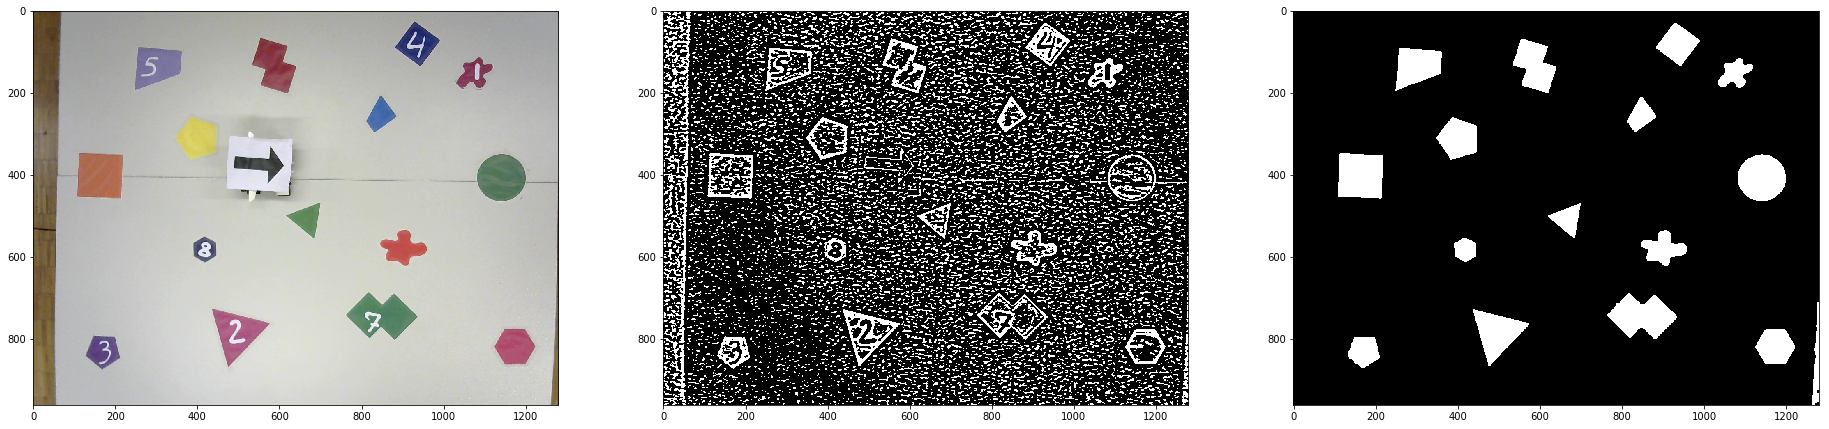

In [4]:
#================================
# parameter
min_shape = 2000 # Area of smallest shape
floor_part = 60 # Width of the floor part(on the left of the image)

#================================
# Set the input image
input_image = image

# Check the luminance from HSV color map and normalize them
hsv_input = cv.cvtColor(input_image,cv.COLOR_RGB2HSV)

mean_v = hsv_input[:,:,2].mean() # Calculate the overal luminance of the input image
print(mean_v)

# If the image is too bright, decrease the brightness
if (mean_v > 130):
    hsv_input[:,:,2] = hsv_input[:,:,2] * 0.9
# If the image is too dark, increase the brightness
else:
    hsv_input[:,:,2] = hsv_input[:,:,2] * 1.3

#Detect the black arrow and remove this part
lower = np.array([0,0,0]);
upper = np.array([255,255,50]);
image_black = cv.inRange(hsv_input,lower,upper)
image_black = cv.morphologyEx(image_black, cv.MORPH_OPEN, np.ones((2,2),np.uint8),iterations = 2) 

norm_hsv_input = cv.cvtColor(hsv_input,cv.COLOR_HSV2RGB)
blur = cv.blur(hsv_input[:,:,1],(2,2))
blur = ~blur

# Threshold the gray image
threshed_im= cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,13,3)

# Morphology process on the threshold image 
# Remove small noises on the image
inv_closed_im = ~(threshed_im | image_black)
rmnoise_im = morphology.remove_small_objects(inv_closed_im.astype(bool), min_size=150).astype(np.uint8)

kernel = np.ones((3,3),np.uint8)
closing = cv.morphologyEx(rmnoise_im, cv.MORPH_CLOSE, kernel,iterations = 3)

# Fill holes of the objects with closed boundaries
clean_im = binary_fill_holes(closing,structure=np.ones((3,3))).astype(np.uint8)
clean_im = morphology.remove_small_objects(clean_im.astype(bool), min_size=min_shape).astype(np.uint8)

# In our experiement, there are floor part in the image so make it black.
clean_im[:,0:floor_part] = 0

# And again remove the small particles
kernel2 = np.ones((5,5),np.uint8)
processed_im = cv.morphologyEx(clean_im, cv.MORPH_OPEN, kernel2,iterations = 1)
processed_im = morphology.remove_small_objects(processed_im.astype(bool), min_size=min_shape).astype(np.uint8)

# Visualize the result
fig, ax = plt.subplots(1,3 , figsize=(32,22))
ax[0].imshow(input_image, cmap='gray')
ax[1].imshow(inv_closed_im, cmap='gray')
ax[2].imshow(processed_im,cmap='gray')

###     2. Separte the objects into holes and pieces.  If objects are pieces, recognize the numbers written on them.

Number of objects detected in total are 16
Number of the objects that we are interested in are 15
Number of pieces are 7
Number of holes are 8
[3, 2, 7, 8, 1, 5, 4]


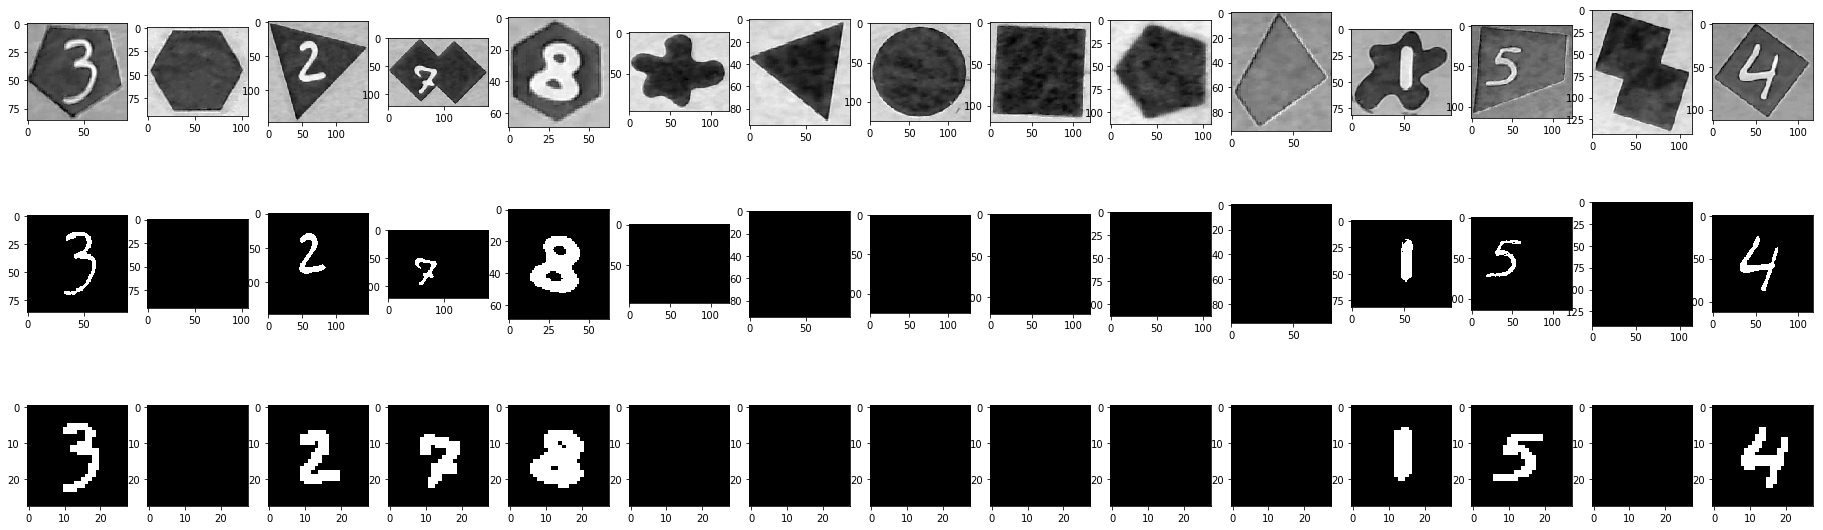

In [6]:
#================================
# parameters
min_elong = 0.5
max_elong= 2.0
min_area_to_resize = 800
min_num_pix = 300 # minimum number of pixels for NUMBERS
num_lower_th = 200 # Threshold for detecting the numbers (original 155)

#================================

# image info
im_w = input_image.shape[0]
im_h = input_image.shape[1]

# Find the contour of the objects
im, contours, hierarchy = cv.findContours(processed_im.copy(),cv.RETR_LIST,cv.CHAIN_APPROX_SIMPLE)
print('Number of objects detected in total are', len(contours))

# If you want to see the part of the image, un-comment this part
fig, ax = plt.subplots(3,15 , figsize=(32,10))
i =0

## Distinguish pieces and holes among the detected objects
pieces = [] # Objects with number
holes =[] # Objects without number
num_list=[] # Detected number on the pieces
for c in contours:
    # The objects of our interest are not too elongated objects.
    x,y,w,h = cv.boundingRect(c)
    area = cv.contourArea(c)
    perimeter = cv.arcLength(c,True)

    if(min_elong < w/h < max_elong):
        
        # Crop the part of the object
        image_part = input_image[max(0,y-5):min(im_w,y+h+5), max(0,x-5):min(im_h,x+w+5)]
        clean_part = processed_im[max(0,y-5):min(im_w,y+h+5), max(0,x-5):min(im_h,x+w+5)]

        # If the object is too small, resize the image and store bigger
        if(area < min_area_to_resize):
            image_part = cv.resize(image_part, (50, 50))
            clean_part = cv.resize(clean_part, (50, 50))

        # Find the objects with numbers inside  
        gray_input = image_part[:,:,2]
        ret, threshed_im = cv.threshold(gray_input,num_lower_th,255,cv.THRESH_BINARY_INV)
        inside_object = (~threshed_im) & clean_part
        inside_object = morphology.remove_small_objects((inside_object).astype(bool), min_size=30).astype(np.uint8)
            
        # If you want to see the part of the image, un-comment this part
        ax[0][i].imshow(gray_input, cmap = 'gray')
        ax[1][i].imshow(inside_object, cmap = 'gray')
        
        
        # Count the number of white pixel in the image
        if(np.sum(inside_object) > min_num_pix):            
            # Find a contour of the number and take the part where the number is located
            im, numcontours, hierarchy = cv.findContours(inside_object.copy(),cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
            maxcontour = max(numcontours,key = cv.contourArea)
            x,y,w,h = cv.boundingRect(maxcontour)
            num_pic = inside_object[max(0,y-30):min(im_w,y+h+30), max(0,x-30):min(im_h,x+w+30)]
            
            # Resize the number in 28x28 to feed into the model.
            resized_num_pic = cv.resize(num_pic,(28,28))
            
            # Blur the image
            resized_num_pic = cv.blur(resized_num_pic, (2,2))
            
            # Detect the number and append it in the list
            res = test_model.classify(resized_num_pic)
            num_list.append(res[0])
            
            # Append the contour of pieces in the list
            pieces.append(c)
            
        else:            
            # Append the contour of holes in the list
            holes.append(c)
            resized_num_pic = np.zeros((28,28))
            
        # If you want to see the part of the image, un-comment this part    
        ax[2][i].imshow(resized_num_pic, cmap = 'gray')
        
        i+= 1
        
print('Number of the objects that we are interested in are', len(pieces) + len(holes))            
print('Number of pieces are', len(pieces))
print('Number of holes are', len(holes))
print(num_list)

### 4. Detect the circle and remove it from the list of objects while storing its position separately.

We found a circle by computing the compacity of the object and choosing the minimum. 

In [7]:
# Find a circle from the holes and get the location and remove it from the list
holes_no_circle, circle_loc = find_circle(holes.copy())

print('The location of the circle is ',circle_loc[0])
print('The number of the hole was',len(holes))
print('NOW the number of the hole is ', len(holes_no_circle))

The computed compacities of inputs are  [15.04085352 26.82139564 22.63076714 14.30412834 16.48576482 16.16620231
 18.37754284 24.04636905]
The index of the circle is  3
The location of the circle is  [1140.1595092   407.17791411]
The number of the hole was 8
NOW the number of the hole is  7


### 5. For every pieces, find the matching holes.

In [8]:
# Find a triangle from the pieces
shape_ID = 0
for piece_ut in pieces:
    shape_ut, center_ut = detect_shape(piece_ut);
    if shape_ut == 'triangle':
        triangle_piece = pieces.pop(shape_ID);
        center_triangle_piece = center_ut
        num_triangle = num_list.pop(shape_ID);
    shape_ID = shape_ID+1;
    
# Find a triangle from the holes and remove it    
shape_ID=0;
for piece_ut in holes_no_circle:
    shape_ut, center_ut = detect_shape(piece_ut);
    if shape_ut == 'triangle':
        triangle_hole = holes_no_circle.pop(shape_ID);
        center_triangle_hole = center_ut
    shape_ID = shape_ID+1;

In [9]:
# Create a list that contains unmatched pieces and holes
unmatched_pieces = []
for i, p in zip(range(len(pieces)),pieces):
    if(p.all() != None): 
        unmatched_pieces.append((p,i))
unmatched_holes = holes_no_circle
print('The number of holes that are ', len(unmatched_holes))
print('The number of pieces that are ', len(unmatched_pieces))

The number of holes that are  6
The number of pieces that are  6


### 6. Create a dictionary of the position of every objects. 

In [10]:
# Create an dictionary whose key is the number and the value is the center of the pieces and holes
detection = {}
matching_contour = {}

# Apply matchShapes on unmatched holes/pieces (greedy algorithm)
while(len(unmatched_pieces)>0):

    # Initialize the matrix to compute the similarity of every pieces and holes
    similarity_array = np.zeros((len(unmatched_pieces),len(unmatched_holes)))
    for i,piece_couple in zip(range(len(unmatched_pieces)),unmatched_pieces):
        for j,h in zip(range(len(unmatched_holes)),unmatched_holes):
            similarity_array[i,j] = cv.matchShapes(h,piece_couple[0],1,0.0)
            
    min_loc=np.where(similarity_array==similarity_array.min())
    i_min = min_loc[0][0]
    j_min = min_loc[1][0]

    piece_min = unmatched_pieces[i_min];
    hole_min = unmatched_holes[j_min];
    
    M = cv.moments(piece_min[0])
    c_width = int((M["m10"] / M["m00"]))
    c_height = int((M["m01"] / M["m00"]))
    center_p = (c_width,c_height)
        
    M = cv.moments(hole_min)
    c_width = int((M["m10"] / M["m00"]))
    c_height = int((M["m01"] / M["m00"]))
    center_h = (c_width,c_height)

    detection[piece_min[1]]=(num_list[i_min],center_p, center_h)
    matching_contour[piece_min[1]]= piece_min[0], hole_min
    unmatched_pieces.pop(i_min);
    unmatched_holes.pop(j_min);
    num_list.pop(i_min);

# Add the triangle location in the detection list 
matching_contour[len(pieces)] = triangle_piece, triangle_hole
detection[len(pieces)]=((num_triangle,center_triangle_piece,center_triangle_hole))

# Print out the detection result
detection

{0: (3, (172, 828), (402, 310)),
 2: (8, (419, 581), (1173, 817)),
 5: (4, (935, 80), (163, 401)),
 1: (7, (849, 743), (587, 133)),
 4: (5, (301, 133), (846, 254)),
 3: (1, (1075, 152), (901, 578)),
 6: (2, (496, 784), (667, 507))}

### Finally, check the result of our detection.

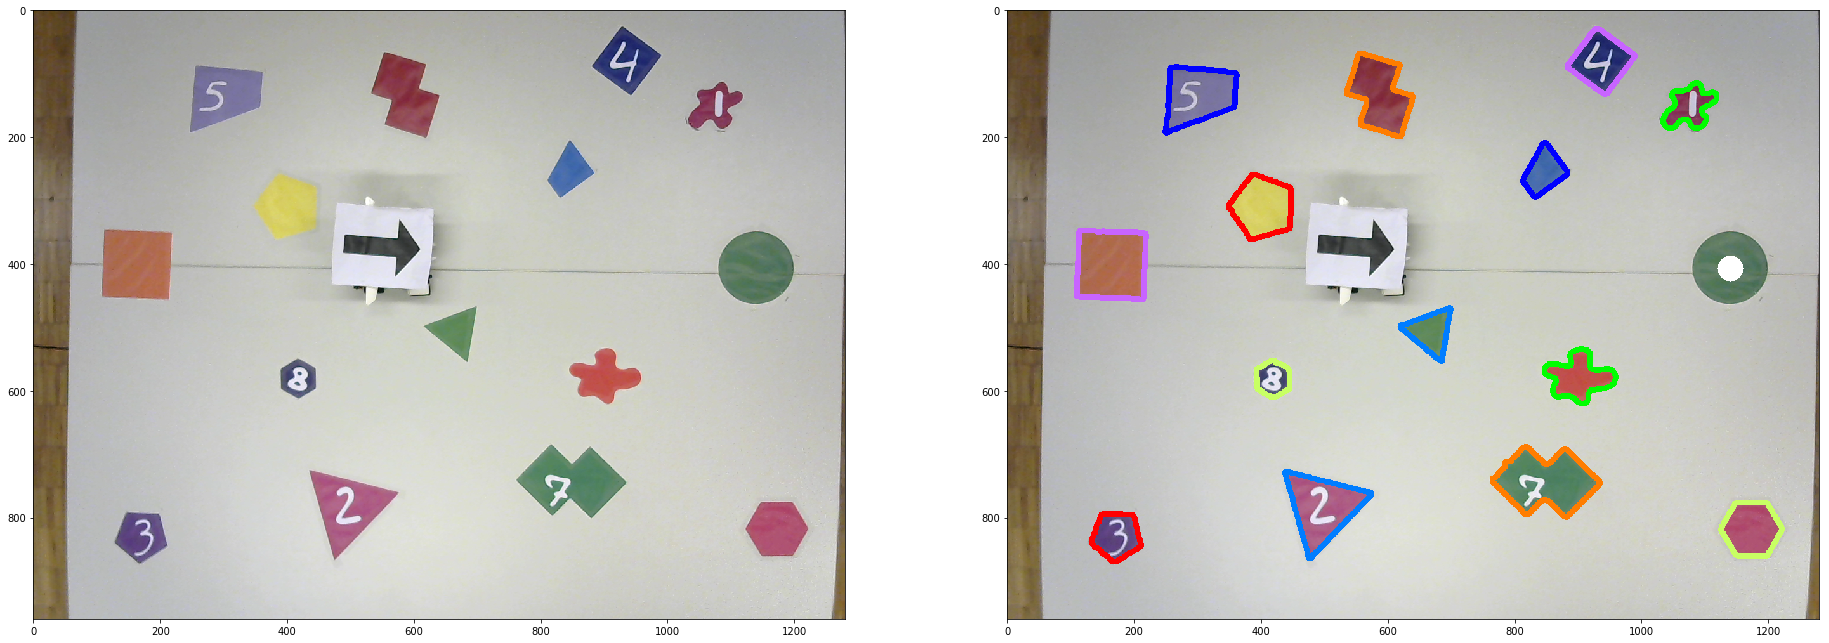

In [11]:
# Color list for visulaization
colors = [(255,0,0),(255,125,0),(200,255,100),(0,255,0),(0,0,255),(200,100,255),(0,125,255)]

# copy the image for the contour visualization
contour_im = input_image.copy() 

for i in range(len(detection)):
    cv.drawContours(contour_im, matching_contour[i], -1, colors[i] , 7)
    
# Spot the ending point
cv.circle(contour_im,tuple(circle_loc[0].astype(int)), 20, (255,255,255), -1)


# Visualize the result
fig, ax = plt.subplots(1,2 , figsize=(32,22))
ax[0].imshow(input_image, cmap='gray')
ax[1].imshow(contour_im,cmap='gray')

## Part2. Arrow Detection and Move Robot

Our method:

    1. Arrange the detected locations of the shapes in order. 
    2. Detect the arrow location and its angle direction.
    3. Calculate the distance and angle between the robot and the object and move the robot.


### 1. Arrange the detected locations of the shapes in order. 

We have made some helper functions that can sort the detections in ascending number orders and also add the ending destination(which is circle in our case.) 
    - sort_dict_by_first_value_tuple
    - make_dict_from_list
    - add_ending_point

From location of the shapes('detection' variable), we extract two lists that tell us what is our desired trajectory of the robot.

In [12]:
def add_ending_point(ordered_digit, ordered_location, circle_location):
    '''
     Add the last location that we need to go and label it as 'Circle'.
     
    '''
    # Add the circle location 
    ordered_location.append(circle_location)
    # Add the label as 'Circle'
    ordered_digit.append("Circle")
    
    return ordered_digit, ordered_location

In [13]:
# Process the detection to our desired format
ordered_digit, ordered_location = make_dict_from_list(detection)
ordered_digit, ordered_location = add_ending_point(ordered_digit, ordered_location, circle_loc[0])
print('ordered_digit', ordered_digit)
print('ordered_location', ordered_location)

ordered_digit [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 7, 7, 8, 8, 'Circle']
ordered_location [(1075, 152), (901, 578), (496, 784), (667, 507), (172, 828), (402, 310), (935, 80), (163, 401), (301, 133), (846, 254), (849, 743), (587, 133), (419, 581), (1173, 817), array([1140.1595092 ,  407.17791411])]


### 2. Detect the arrow location and its angle direction.

Since the arrow is the black object in the image, we first filtered black part of the image and detected the arrow using region growing method. After we get a location of the arrow, we also calculated the angle where the arrow is pointing. This procedure is done in the function 'arrow_location'. 

We have also implemented several helper functions for this step. 
    - growingRegion
    - rad2degree
    - angleininterval   

In [24]:
def arrow_location(image,cropping,black_range,perm):
    '''
    Process the input image and return the arrow location and its angle of its point
    
    '''
    
    # Modify the input image to remove the unwanted part
    h,w,c = image.shape;
    image = image[cropping[0]:h-cropping[1],cropping[2]:w-cropping[3],:]
    
    # Detect the black arrow
    lower = np.array([0,0,0]);
    upper = np.array([black_range,black_range,black_range]);
    image_black = cv.inRange(image,lower,upper)


    # Hard opening to retrieve only the (part of)arrow
    kernel = np.ones((25,25),np.uint8)
    arrow_heart = cv.morphologyEx(image_black, cv.MORPH_OPEN, kernel)
    upper = np.array([black_range+perm,black_range+perm,black_range+perm]); # Redefine a more permissive black picture
    image_black = cv.inRange(image,lower,upper)
       
    # Display the image
    fig, ax = plt.subplots(1,3, figsize=(10,20))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[1].imshow(arrow_heart)
    ax[1].axis('off')
    
    # Get the full arrow using region growing
    # Pick one pixel in the arrow from 'arrow_heart'
    min_temp=0
    max_temp=0 
    min_loc_temp=[0,0]
    start_point =[0,0]
    min_temp, max_temp, min_loc_temp, start_point=cv.minMaxLoc(arrow_heart);
    
    # Grow region of the arrow to get it completely
    arrow_pixels = growingRegion(image_black,start_point,127);
    arrow_image = np.zeros(arrow_heart.shape)
    for pixel in arrow_pixels:
        arrow_image[pixel[1],pixel[0]]=256;

    #Retrieve information on the arrow
    arrow_center = np.mean(np.asarray(arrow_pixels),0)  #Center of the arrow
    arrow_center[0] += cropping[2]
    arrow_center[1] += cropping[0]
    
    #Angle of the arrow (plus or minus)
    moments = cv.moments(arrow_image)
    angle_plusminus = -(1/2)*np.arctan(2*moments["mu11"]/(moments["mu20"]-moments["mu02"]))

    rotated_arrow = imutils.rotate_bound(arrow_image,angle_plusminus*360/(2*np.pi))
    min_temp, max_temp, min_loc_temp, start_point=cv.minMaxLoc(rotated_arrow);
    
    # Retrieve a list of point composing the rotated arrow
    # to check if the arrow horizontal (good) or vertical (bad)
    rotated_arrow_pixels = growingRegion(rotated_arrow,start_point,10.0); 
    rotated_arrow_center = np.mean(np.asarray(rotated_arrow_pixels),0) # Find its center
    square_diff = sum((rotated_arrow_pixels-rotated_arrow_center)**2);
    if square_diff[1]>square_diff[0]:
        angle_plusminus = angle_plusminus + math.pi/2;       
    rotated_arrow = imutils.rotate_bound(arrow_image,angle_plusminus*360/(2*np.pi))
    # Display the image of the rotated arrow
    ax[2].imshow(image_black)
    ax[2].axis('off')
    
    #Sign of the angle to check where the tip is on the right or on the left of the center of the rotated arrow
    min_temp, max_temp, min_loc_temp, start_point=cv.minMaxLoc(rotated_arrow);
    #Retrieve a list of point composing the rotated arrow
    rotated_arrow_pixels = growingRegion(rotated_arrow,start_point,10.0); 
    rotated_arrow_pixels = np.asarray(rotated_arrow_pixels);
    rotated_arrow_center = np.mean(np.asarray(rotated_arrow_pixels),0) # Find its center
    min_temp, max_temp, top_arrow_id, max_loc_temp=cv.minMaxLoc(rotated_arrow_pixels[:,1]);
    top_point=rotated_arrow_pixels[top_arrow_id[0],:];

    if top_point[0]<rotated_arrow_center[0]:
        angle = angle_plusminus+np.pi;
    else:
            angle = angle_plusminus;
        
    rotated_arrow = imutils.rotate_bound(arrow_image,angle*360/(2*np.pi))  
    plt.show();

    return arrow_center, angleininterval(rad2degree(angle))

To avoid having big black part occured by the floor part of the image, we first compute the ROI in the image and then look for an arrow. 

The ROI part of the image is  52 1279 0 959


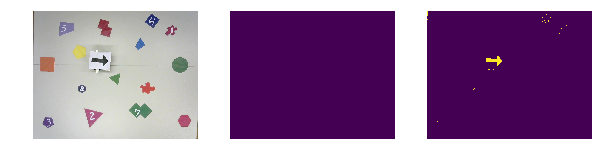

In [20]:
#================================
# parameters 
margin = 7 # Original margin = 7
black_thresh = 50
#================================


# Initialize the parameters
x_min = 1000;
y_min = 1000;
x_max = 0;
y_max = 0;

# Threshold the image to the black
tresh_image = cv.inRange(input_image.copy(), (130,130,130), (255,255,255));
h,w,c = input_image.shape;

# Find the x,y coordinate of the ROI part of the image.
for y in range(0,h):
    for x in range(0,w):
        if tresh_image[y,x]==255:
            if x< x_min:
                x_min = x;
            if y< y_min:
                y_min = y;
            if y> y_max:
                y_max = y;
            if x> x_max:
                x_max = x;
print('The ROI part of the image is ', x_min,x_max,y_min,y_max)

# Get the ROI range and apply it when looking for an arrow.
cropping_ROI = [y_min+margin, h-y_max+margin,x_min+margin, w-x_max+margin]
arrow_center, angle = arrow_location(input_image,cropping_ROI,black_thresh,40)

### 3. Calculate the distance and angle between the robot and the object and move the robot.

In the next function the feedback loop is realised. 

1. Find where the arrow is, then using 'get_angle_distance', we decide how much far away we are from desired location. 
2. Turn the robot until it is pointing the direction towards where it should go.
3. Move robot towards the destination by min(max_go, go_distance) where ``max_go`` is the maximum distance that robot can move and ``go_distance`` is the distance between robot and the destination.
4. Do the step 1, 2 and 3 until the robot reaches to the destination. 
5. When the robot reached the destination, it realease the 'beep' sound.

The loop is executed for all the objects that we have detected in the previous part.  Since the robot could not turn its angle very much as we want, we had to move robot little by little when going for the destination with feedback on the angle to the destination. 

In [21]:
def take_shapes_modif(ordered_digit, ordered_location, turn_thresh = 0, go_thresh = 10, max_go  = 30, black_thresh=70):
    
    '''
    Detect an arrow and its pointing direction and move the robot to the destination. 
    
    << Parameters >>
    ordered_digit : A list of number of the location
    ordered_location: A list of position of the objects
    turn_thresh : A range buffer of an arrow's direction and the destined angle.
    go_thresh : A range buffer of how close the arrow should be to the destined position.
    max_go : the maximum distance that robot can move.
    black_thresh : The maximum threshold of the black part in the image(This value is passed to the arrow_location function)
    
    '''
    
    num_of_objects = len(ordered_location)  # Number of objects that we have to detect
    taken_objects =  0  # Detected objects
    
    # As long as we have not visited all locations
    while (taken_objects<num_of_objects):
        
        # Get the destination
        object_location = ordered_location[taken_objects]
        print("Destination object_location", object_location)
        
        # Read image and get an arrow information
        image = wvs.read()
        arrow_center, angle_arrow = arrow_location(image,cropping_ROI,black_thresh,40)
        
        # Calculate how much we have to turn and go to reach our destination.
        obj_angle, go_distance = get_angle_distance(arrow_center, object_location)
        turn_angle = angleininterval(obj_angle-angle_arrow)

        # Until we reached the object...
        while (go_distance>go_thresh):
            
            # Settle the direction that a robot will move towards
            while ((turn_angle>turn_thresh and turn_angle>0) or (-turn_thresh>turn_angle and turn_angle<0)):
                robot.steer_in_place(turn_angle)
                
                # Read image and get an arrow information
                image = wvs.read()
                arrow_center, angle_arrow = arrow_location(image,cropping_ROI,black_thresh,40)
                
                # Calculate how much we have to turn and go to reach our destination.
                obj_angle, go_distance = get_angle_distance(arrow_center, object_location)
                turn_angle = angleininterval(obj_angle-angle_arrow)
                print("arrow angle",angle_arrow)
                print("object angle",obj_angle)
                
                # Convert pixel distance to the cm
                go_distance= pixel_to_cm(go_distance)
                print("turn_angle IN ANGLE",turn_angle)
                print("go_distance IN ANGLE",go_distance)
            
            # Move robot forward 
            robot.move_forward(min(go_distance, max_go))
            
            # Read image and get an arrow information
            image = wvs.read()
            arrow_center, angle_arrow = arrow_location(image,cropping_ROI,black_thresh,40)
            
            # Calculate how much we have to turn and go to reach our destination.
            obj_angle, go_distance = get_angle_distance(arrow_center, object_location)
            turn_angle = angleininterval(obj_angle-angle_arrow)
                            
            # Convert pixel distance to the cm    
            go_distance= pixel_to_cm(go_distance)
            print("turn_angle IN DISTANCE",turn_angle)
            print("go_distance IN DISTANCE",go_distance)
            
        taken_objects +=1
        print('Reached objects: ', taken_objects)
        
        # When reached the destination, alarm with sound
        robot.beep(count=1)
        
        # Print appropriate message about which shape we have reached
        if ((taken_objects-1)%2==0):
            print("We took ", ordered_digit[taken_objects-1])
        elif (taken_objects-1!=num_of_objects):
            print("We realise ", ordered_digit[taken_objects-1])
    
    # Finishing the task, beep three times        
    print("\n We finished")
    robot.beep(count=3)

## Now run the robot to do its task!!!

Destination object_location (1075, 152)


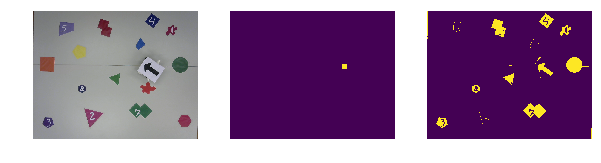

angle 61.92921557401087


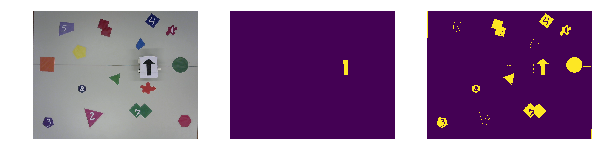

angle 57.85753592672391
arrow angle 90.60063213936702
object angle 57.85753592672391
turn_angle IN ANGLE -32.74309621264308
go_distance IN ANGLE 41.078432705074036


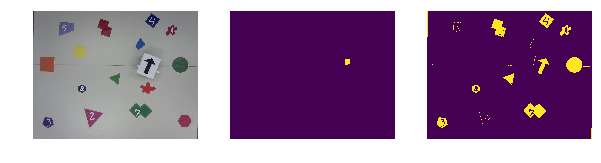

angle 57.33596424181176
arrow angle 66.72983078633042
object angle 57.33596424181176
turn_angle IN ANGLE -9.393866544518687
go_distance IN ANGLE 39.921677969106504


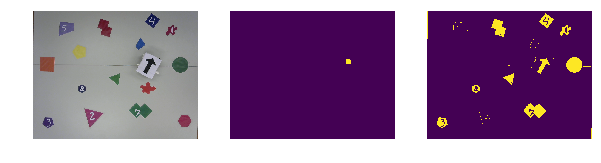

angle 57.43592157398366
arrow angle 61.303309434058825
object angle 57.43592157398366
turn_angle IN ANGLE -3.867387860075155
go_distance IN ANGLE 39.603025195603095


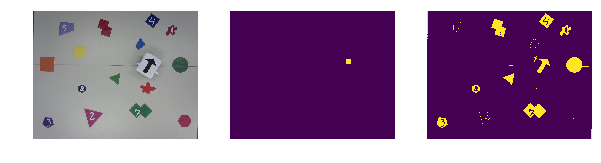

angle 57.52914954289658
arrow angle 57.5640096114173
object angle 57.52914954289658
turn_angle IN ANGLE -0.03486006852074297
go_distance IN ANGLE 39.4871148614621


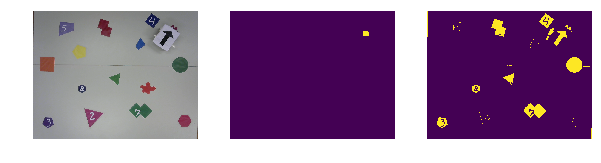

angle 53.769449291582184
turn_angle IN DISTANCE 0.20075583032794952
go_distance IN DISTANCE 7.805882361328537


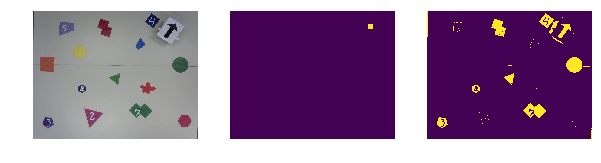

angle -47.713636795181465
turn_angle IN DISTANCE -101.46062396059051
go_distance IN DISTANCE 0.7495119718843446
Reached objects:  1
We took  1
Destination object_location (901, 578)


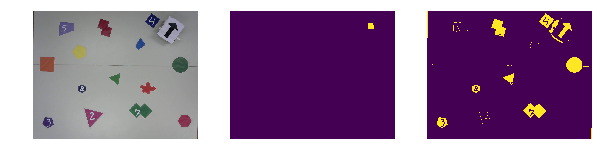

angle -111.67860597226095


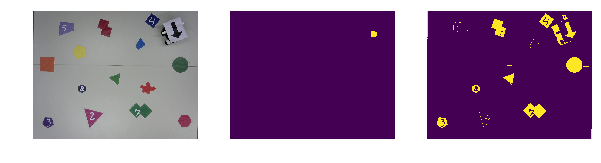

angle -115.78541575338247
arrow angle -69.67838153545733
object angle -115.78541575338247
turn_angle IN ANGLE -46.10703421792516
go_distance IN ANGLE 62.07814455300573


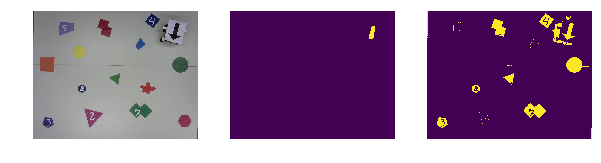

angle -116.13428848801189
arrow angle -105.64446750033838
object angle -116.13428848801189
turn_angle IN ANGLE -10.489820987673511
go_distance IN ANGLE 60.65976237486538


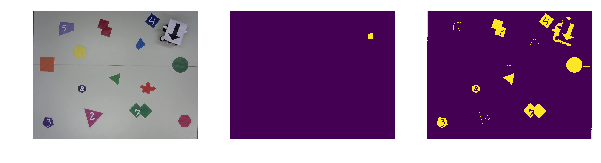

angle -116.12823734886393
arrow angle -111.21642760562989
object angle -116.12823734886393
turn_angle IN ANGLE -4.911809743234016
go_distance IN ANGLE 60.33362343626065


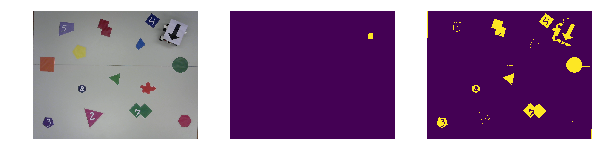

angle -116.06998633099684
arrow angle 64.9626188018973
object angle -116.06998633099684
turn_angle IN ANGLE 178.96739486710584
go_distance IN ANGLE 60.22470848400819


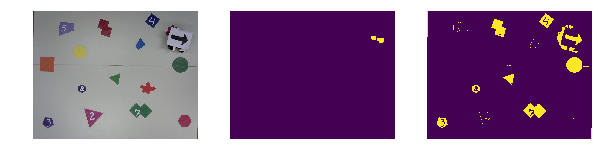

angle -123.19578672172585
arrow angle -14.93642448353296
object angle -123.19578672172585
turn_angle IN ANGLE -108.25936223819289
go_distance IN ANGLE 57.380623769655955


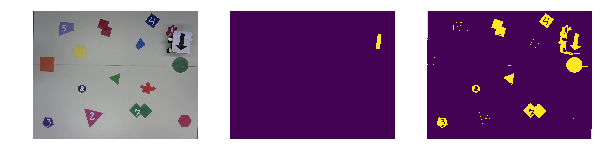

angle -126.54580597882794
arrow angle -97.09779139925945
object angle -126.54580597882794
turn_angle IN ANGLE -29.448014579568508
go_distance IN ANGLE 55.21203861315925


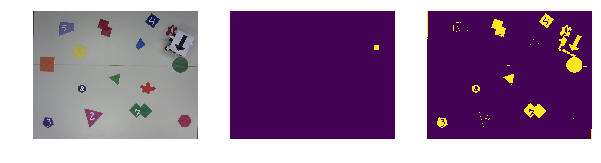

angle -126.96632730043112
arrow angle -118.0532928678092
object angle -126.96632730043112
turn_angle IN ANGLE -8.913034432621885
go_distance IN ANGLE 54.20933454541034


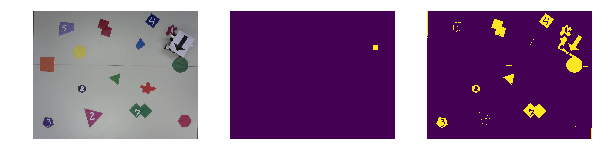

angle -126.90478917332129
arrow angle -124.08487921364025
object angle -126.90478917332129
turn_angle IN ANGLE -2.819909959681013
go_distance IN ANGLE 53.889325667698465


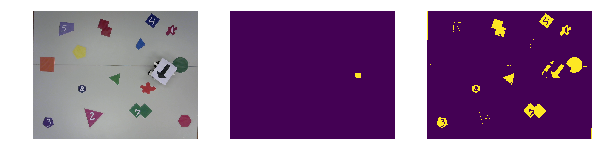

angle -133.9544671988171
turn_angle IN DISTANCE -7.1476528909566355
go_distance IN DISTANCE 22.090554478032168


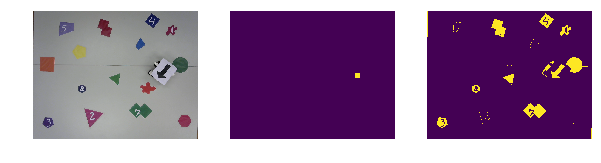

angle -134.01174738878993
arrow angle -129.67324040853936
object angle -134.01174738878993
turn_angle IN ANGLE -4.3385069802505996
go_distance IN ANGLE 22.007924282834182


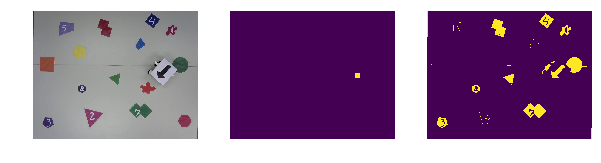

angle -133.90322378947187
arrow angle -133.1547040240641
object angle -133.90322378947187
turn_angle IN ANGLE -0.7485197654077638
go_distance IN ANGLE 21.894215363070685


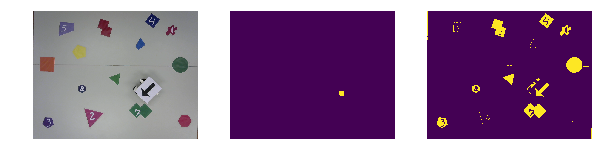

angle 94.71800756127432
turn_angle IN DISTANCE -130.28229373879395
go_distance IN DISTANCE 1.8260281606556847
Reached objects:  2
We realise  1
Destination object_location (496, 784)


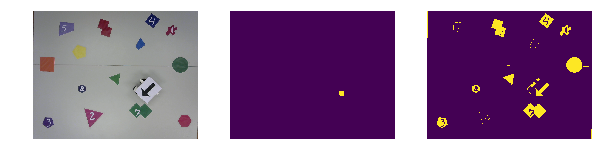

angle -154.6688503144258


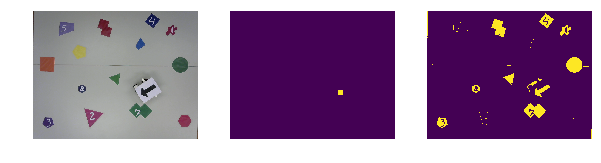

angle -154.79236724142265
arrow angle -57.91466915092218
object angle -154.79236724142265
turn_angle IN ANGLE -96.87769809050047
go_distance IN ANGLE 58.59034910718219


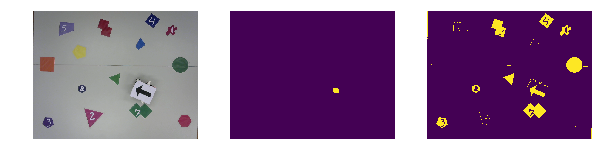

angle -154.00053265417054
arrow angle 155.5009432006908
object angle -154.00053265417054
turn_angle IN ANGLE 50.49852414513862
go_distance IN ANGLE 53.84386412020363


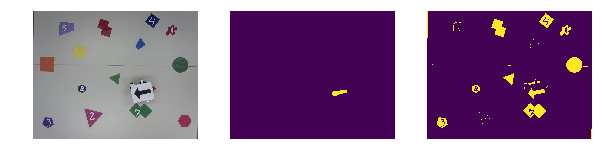

angle -154.16251186271262
arrow angle -169.35487663001936
object angle -154.16251186271262
turn_angle IN ANGLE 15.192364767306742
go_distance IN ANGLE 52.80201390300206


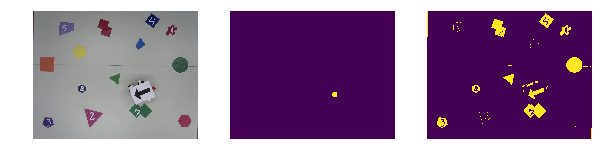

angle -154.35595858727626
arrow angle -158.00983295531225
object angle -154.35595858727626
turn_angle IN ANGLE 3.6538743680359858
go_distance IN ANGLE 52.535303455970976


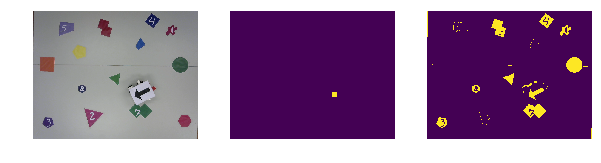

angle -154.5193627777314
arrow angle -154.25241804768262
object angle -154.5193627777314
turn_angle IN ANGLE -0.2669447300487491
go_distance IN ANGLE 52.37606378576204


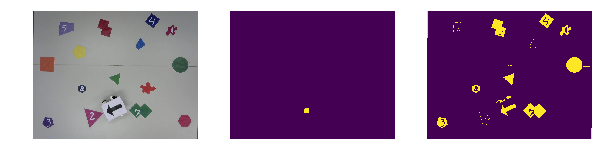

angle -160.91567650222376
turn_angle IN DISTANCE -6.612428843851205
go_distance IN DISTANCE 21.550813896459324


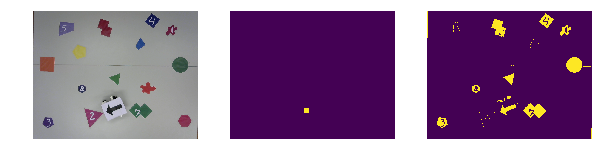

angle -160.91333867196488
arrow angle -157.41850797433744
object angle -160.91333867196488
turn_angle IN ANGLE -3.4948306976274353
go_distance IN ANGLE 21.351072941885185


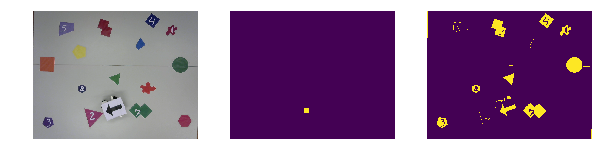

angle -160.88871064102312
arrow angle -159.8544579421196
object angle -160.88871064102312
turn_angle IN ANGLE -1.034252698903515
go_distance IN ANGLE 21.24327698667207


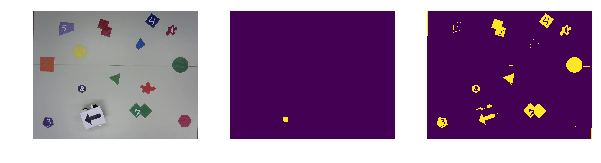

angle 83.81478338851609
turn_angle IN DISTANCE -115.16283712675067
go_distance IN DISTANCE 1.6170188590883434
Reached objects:  3
We took  2
Destination object_location (667, 507)


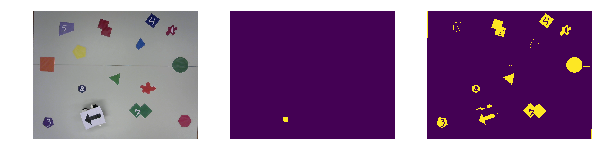

angle 59.202576563453206


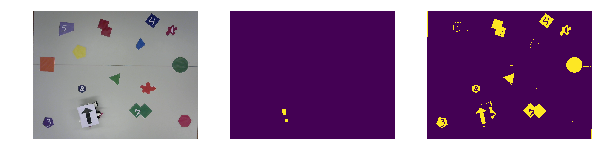

angle 52.62270877289838
arrow angle 103.13305466696244
object angle 52.62270877289838
turn_angle IN ANGLE -50.51034589406407
go_distance IN ANGLE 44.236371421631766


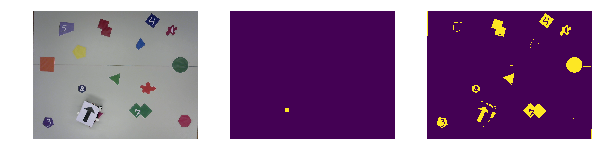

angle 51.79888070383085
arrow angle 65.15001185744043
object angle 51.79888070383085
turn_angle IN ANGLE -13.351131153609572
go_distance IN ANGLE 42.8955817915262


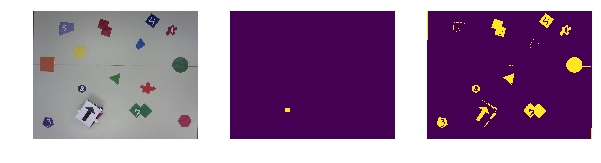

angle 51.79009854152992
arrow angle 55.1394628157453
object angle 51.79009854152992
turn_angle IN ANGLE -3.349364274215361
go_distance IN ANGLE 42.54768014919043


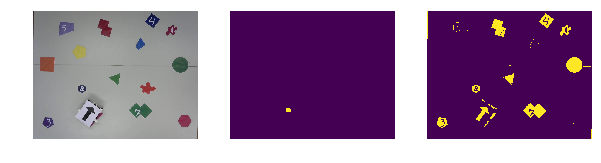

angle 51.74472987700742
arrow angle 53.40741780858616
object angle 51.74472987700742
turn_angle IN ANGLE -1.6626879315787164
go_distance IN ANGLE 42.37055557244822


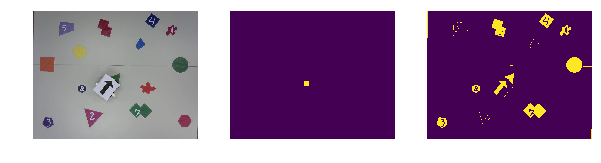

angle 41.29239903226447
turn_angle IN DISTANCE -9.583503249677506
go_distance IN DISTANCE 11.661065335452157


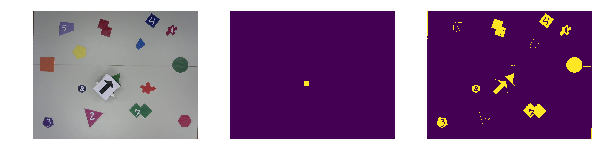

angle 41.37152623059743
arrow angle 46.382188722514904
object angle 41.37152623059743
turn_angle IN ANGLE -5.010662491917458
go_distance IN ANGLE 11.512819066429707


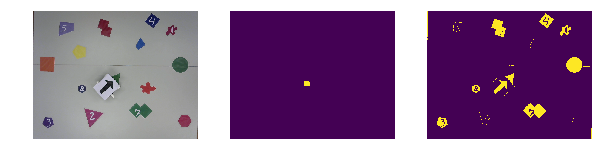

angle 41.30782863608684
arrow angle 42.193069674683
object angle 41.30782863608684
turn_angle IN ANGLE -0.8852410385961775
go_distance IN ANGLE 11.365824469881325


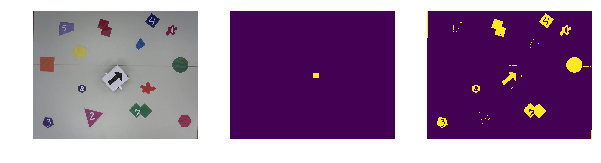

angle -79.38161225792082
turn_angle IN DISTANCE -119.06271616446139
go_distance IN DISTANCE 0.7779492278058684
Reached objects:  4
We realise  2
Destination object_location (172, 828)


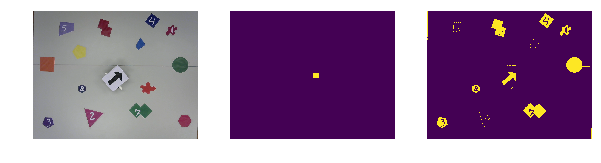

angle -146.51657298746187


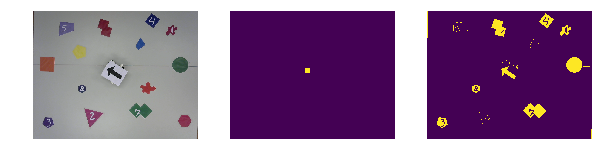

angle -142.84893621327234
arrow angle 146.8378627967385
object angle -142.84893621327234
turn_angle IN ANGLE 70.31320098998913
go_distance IN ANGLE 79.10088115013386


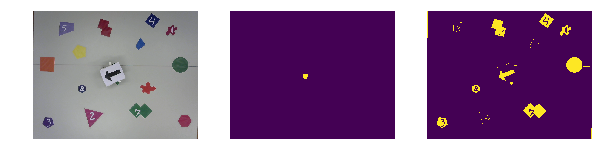

angle -142.9285174216238
arrow angle 23.15649213107177
object angle -142.9285174216238
turn_angle IN ANGLE -166.08500955269557
go_distance IN ANGLE 76.78210653037301


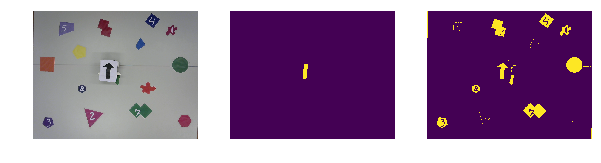

angle -138.9432196952503
arrow angle 84.34809897017965
object angle -138.9432196952503
turn_angle IN ANGLE 136.70868133457006
go_distance IN ANGLE 76.64097515946486


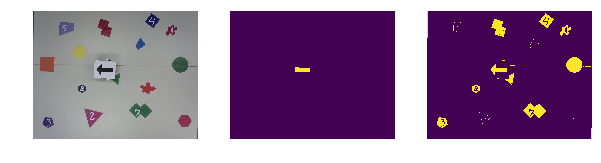

angle -136.5941489368327
arrow angle 176.72578849265966
object angle -136.5941489368327
turn_angle IN ANGLE 46.68006257050763
go_distance IN ANGLE 73.96316758032734


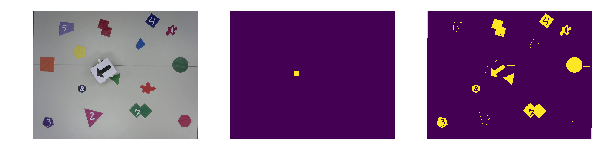

angle -136.69733110716172
arrow angle -145.82158530373056
object angle -136.69733110716172
turn_angle IN ANGLE 9.124254196568842
go_distance IN ANGLE 72.39362025709796


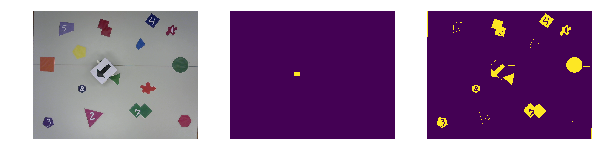

angle -136.86766078928002
arrow angle -137.67134894526671
object angle -136.86766078928002
turn_angle IN ANGLE 0.8036881559866913
go_distance IN ANGLE 72.33401687383255


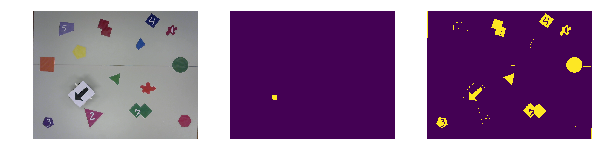

angle -139.36901783847773
turn_angle IN DISTANCE -1.8442300958218993
go_distance IN DISTANCE 41.472900170766536


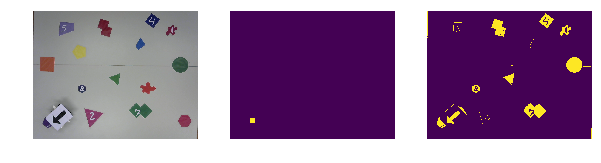

angle -154.91740603463845
turn_angle IN DISTANCE -17.108792224517742
go_distance IN DISTANCE 10.942039165296983


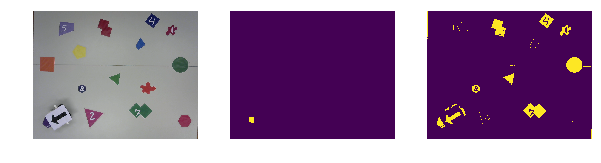

angle -154.95135590590175
arrow angle -148.20676239423224
object angle -154.95135590590175
turn_angle IN ANGLE -6.744593511669507
go_distance IN ANGLE 10.367445853673281


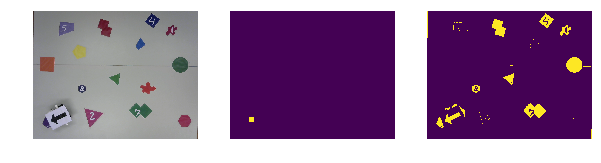

angle -154.71798115504683
arrow angle -153.61679668836916
object angle -154.71798115504683
turn_angle IN ANGLE -1.101184466677637
go_distance IN ANGLE 10.198337671636102


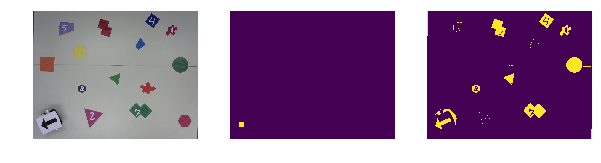

angle 88.98620327274054
turn_angle IN DISTANCE -114.54442271555362
go_distance IN DISTANCE 0.6214466007307835
Reached objects:  5
We took  3
Destination object_location (402, 310)


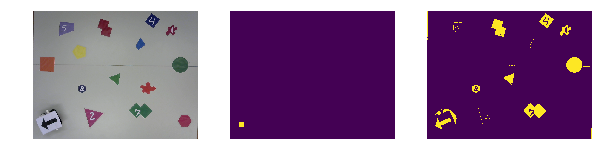

angle 66.24225771036443


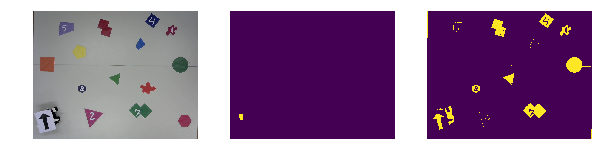

angle 63.26887310164137
arrow angle 103.52866981923559
object angle 63.26887310164137
turn_angle IN ANGLE -40.25979671759421
go_distance IN ANGLE 74.28009196833806


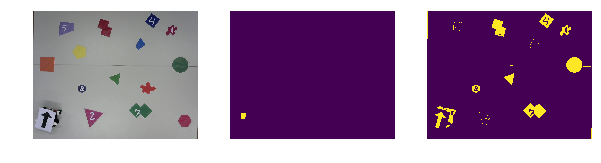

angle 63.10451292565449
arrow angle 73.47970730685446
object angle 63.10451292565449
turn_angle IN ANGLE -10.375194381200004
go_distance IN ANGLE 72.91983057471188


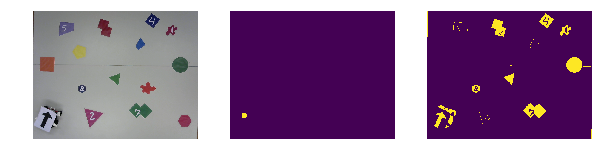

angle 63.11009024840268
arrow angle 65.22660926316053
object angle 63.11009024840268
turn_angle IN ANGLE -2.1165190147578414
go_distance IN ANGLE 72.61812466052785


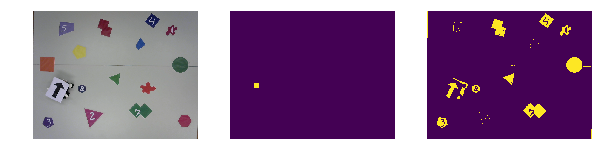

angle 59.56179080412913
turn_angle IN DISTANCE -3.3502765133857793
go_distance IN DISTANCE 41.79466457041286


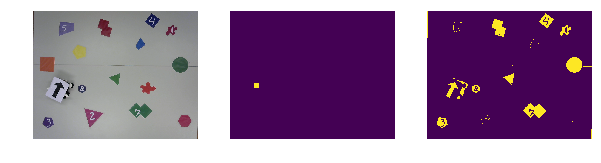

angle 59.518747177364695
arrow angle 62.98377902918523
object angle 59.518747177364695
turn_angle IN ANGLE -3.4650318518205268
go_distance IN ANGLE 41.651772550520185


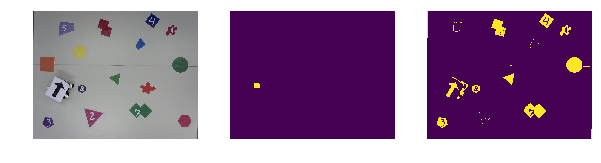

angle 59.53559795928712
arrow angle 59.79154124583052
object angle 59.53559795928712
turn_angle IN ANGLE -0.25594328654341325
go_distance IN ANGLE 41.5275171463485


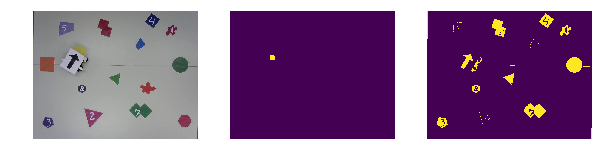

angle 52.046314425597615
turn_angle IN DISTANCE -5.711995422198868
go_distance IN DISTANCE 10.760008639494886


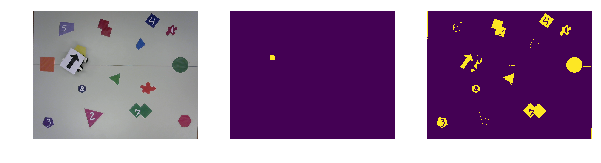

angle 52.0188877273267
arrow angle 55.49804313515909
object angle 52.0188877273267
turn_angle IN ANGLE -3.4791554078323657
go_distance IN ANGLE 10.702794156561662


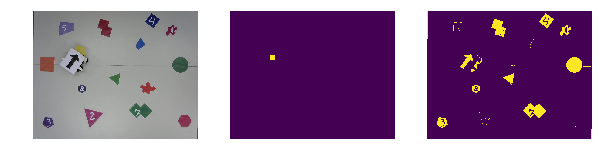

angle 52.146520754029204
arrow angle 54.19949734382144
object angle 52.146520754029204
turn_angle IN ANGLE -2.0529765897922516
go_distance IN ANGLE 10.609329548654728


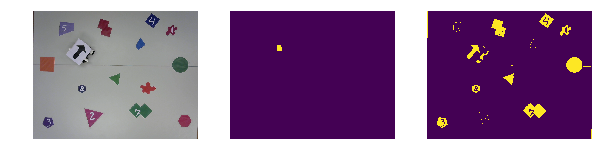

angle -66.3284513509235
turn_angle IN DISTANCE -116.99584163046299
go_distance IN DISTANCE 0.7647804872192508
Reached objects:  6
We realise  3
Destination object_location (935, 80)


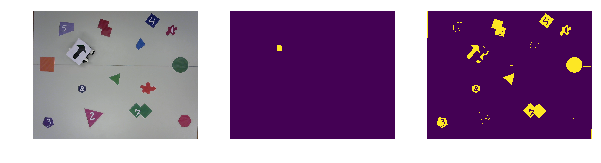

angle 22.71813539958934


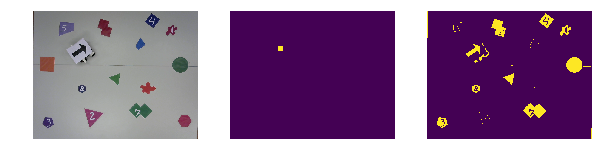

angle 22.385627385106567
arrow angle 34.59931550900214
object angle 22.385627385106567
turn_angle IN ANGLE -12.213688123895565
go_distance IN ANGLE 75.17024897100468


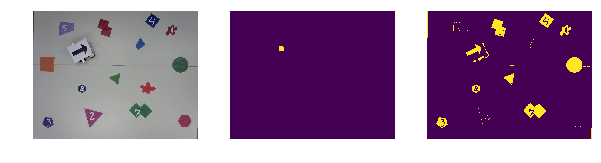

angle 22.453362169227592
arrow angle 25.9877005217294
object angle 22.453362169227592
turn_angle IN ANGLE -3.534338352501834
go_distance IN ANGLE 74.77840626332436


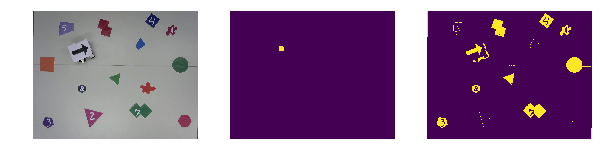

angle 22.48786919434713
arrow angle 21.463049501281574
object angle 22.48786919434713
turn_angle IN ANGLE 1.024819693065556
go_distance IN ANGLE 74.64830282192368


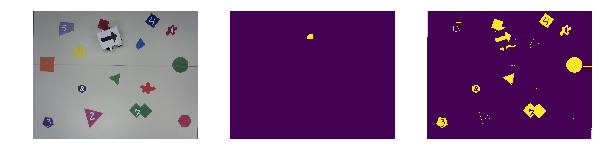

angle 21.723150008134088
turn_angle IN DISTANCE 2.941423039999165
go_distance IN DISTANCE 44.037508617402665


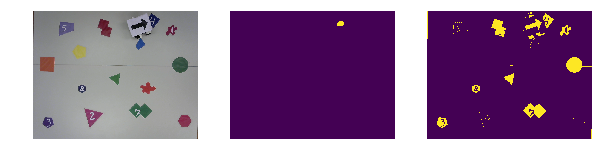

angle 18.34544324932919
turn_angle IN DISTANCE -0.851418000410888
go_distance IN DISTANCE 12.339579194879908


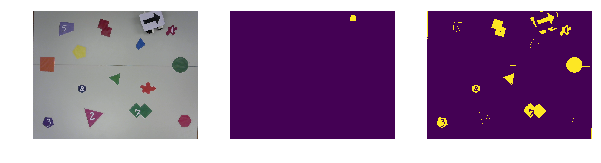

angle -103.89639407163034
turn_angle IN DISTANCE -123.15217491914325
go_distance IN DISTANCE 1.4681475838919136
Reached objects:  7
We took  4
Destination object_location (163, 401)


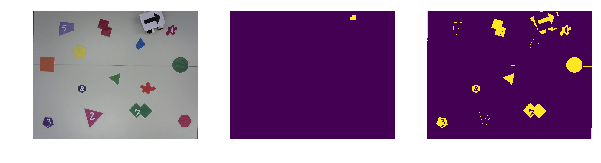

angle -156.80260567046136


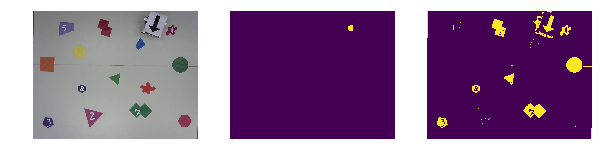

angle -159.6154771711087
arrow angle -110.69912470437251
object angle -159.6154771711087
turn_angle IN ANGLE -48.91635246673616
go_distance IN ANGLE 111.26480292468017


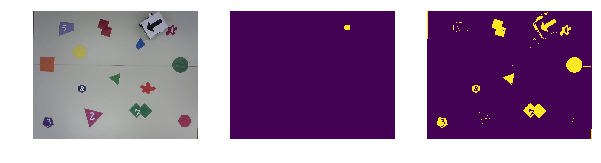

angle -159.6463205458406
arrow angle -148.5605369566406
object angle -159.6463205458406
turn_angle IN ANGLE -11.085783589199991
go_distance IN ANGLE 109.73223658733004


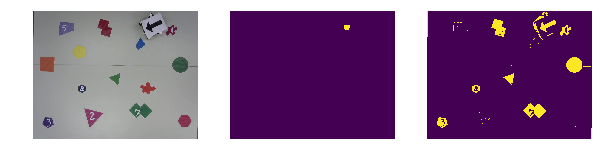

angle -159.7785561474122
arrow angle -155.3217405554367
object angle -159.7785561474122
turn_angle IN ANGLE -4.456815591975499
go_distance IN ANGLE 109.1773330609752


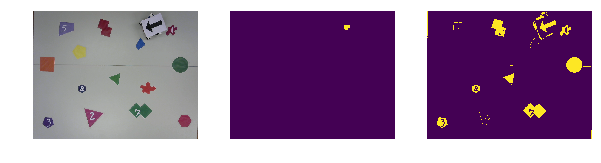

angle -159.79896471920358
arrow angle 21.700851449289868
object angle -159.79896471920358
turn_angle IN ANGLE 178.50018383150655
go_distance IN ANGLE 109.03639568449239


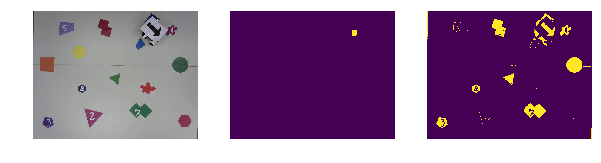

angle -162.07920424058747
arrow angle -43.53611583843514
object angle -162.07920424058747
turn_angle IN ANGLE -118.54308840215234
go_distance IN ANGLE 108.56565973883227


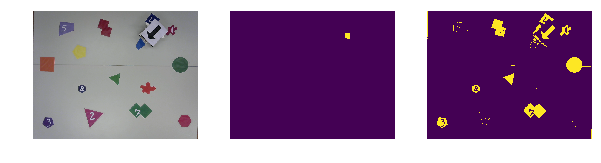

angle -163.38531368693566
arrow angle -135.62239542376602
object angle -163.38531368693566
turn_angle IN ANGLE -27.762918263169638
go_distance IN ANGLE 107.14242986977081


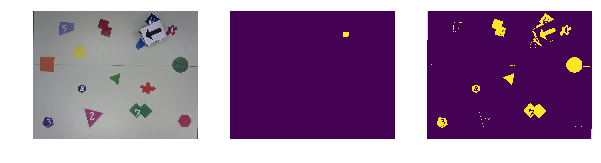

angle -163.32492917011024
arrow angle -155.69910717920618
object angle -163.32492917011024
turn_angle IN ANGLE -7.625821990904058
go_distance IN ANGLE 106.3381789003809


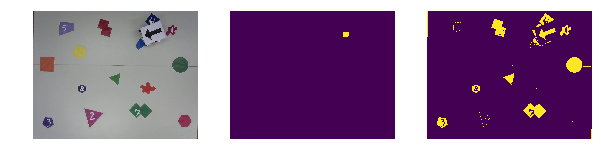

angle -163.31306968549686
arrow angle 19.735039479911972
object angle -163.31306968549686
turn_angle IN ANGLE 176.95189083459118
go_distance IN ANGLE 106.06012852263842


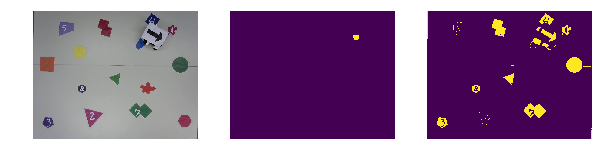

angle -164.84616096452748
arrow angle -30.076838056028123
object angle -164.84616096452748
turn_angle IN ANGLE -134.76932290849936
go_distance IN ANGLE 108.1408102150753


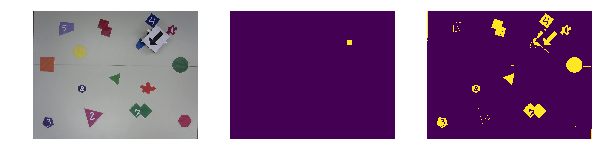

angle -166.79224988037404
arrow angle 47.247494047649326
object angle -166.79224988037404
turn_angle IN ANGLE 145.96025607197663
go_distance IN ANGLE 107.4054036686542


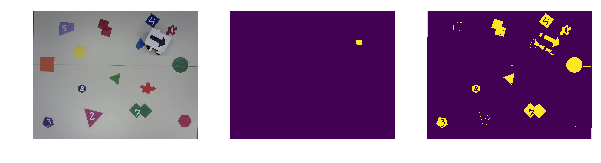

angle -167.85955237552287
arrow angle -28.113341609249346
object angle -167.85955237552287
turn_angle IN ANGLE -139.74621076627352
go_distance IN ANGLE 109.68885837174244


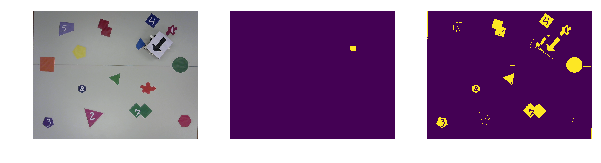

angle -170.21375003194737
arrow angle -130.9933412998984
object angle -170.21375003194737
turn_angle IN ANGLE -39.22040873204901
go_distance IN ANGLE 109.34667185747313


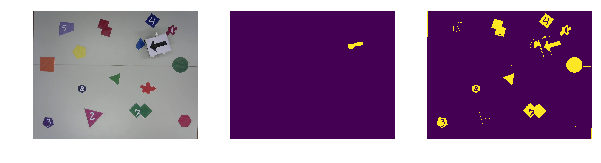

angle -170.04508164385567
arrow angle -164.1067220550447
object angle -170.04508164385567
turn_angle IN ANGLE -5.938359588810954
go_distance IN ANGLE 108.16891648568999


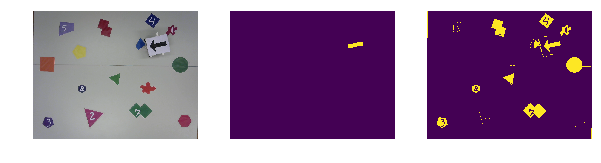

angle -170.02739682884243
arrow angle -167.99676284784064
object angle -170.02739682884243
turn_angle IN ANGLE -2.030633981001756
go_distance IN ANGLE 107.97326455327861


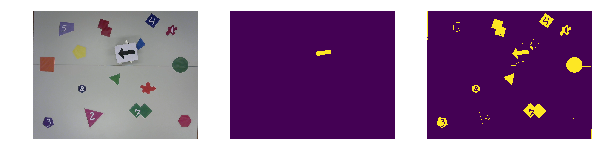

angle -171.60017694325788
turn_angle IN DISTANCE -0.701858246956931
go_distance IN DISTANCE 76.65313112965579


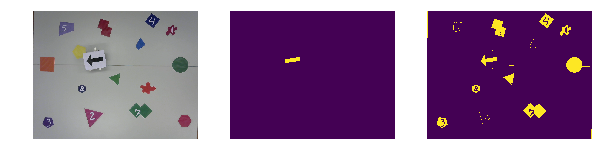

angle -174.86953499187004
turn_angle IN DISTANCE -3.992041392971032
go_distance IN DISTANCE 45.48188247439151


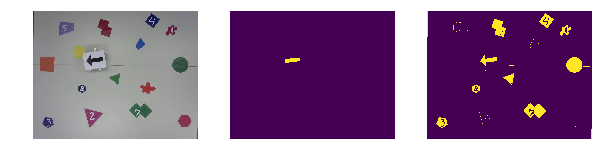

angle -174.91990960936408
arrow angle -171.9105595330213
object angle -174.91990960936408
turn_angle IN ANGLE -3.0093500763427983
go_distance IN ANGLE 45.33530185435901


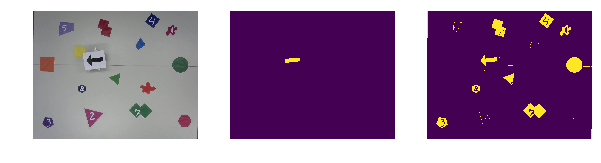

angle -174.88976567511068
arrow angle -173.1031031274496
object angle -174.88976567511068
turn_angle IN ANGLE -1.7866625476610807
go_distance IN ANGLE 45.304574424066914


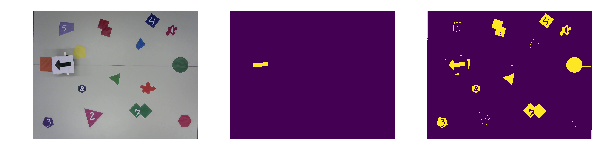

angle 179.00609412584842
turn_angle IN DISTANCE -4.298350295016348
go_distance IN DISTANCE 14.566279648447411


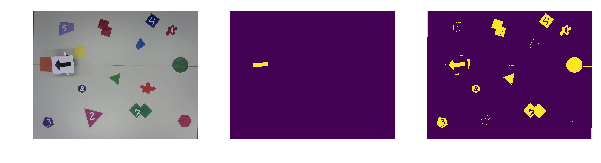

angle 178.93242494759212
arrow angle -176.88632379339785
object angle 178.93242494759212
turn_angle IN ANGLE -4.1812512590100255
go_distance IN ANGLE 14.49844085658253


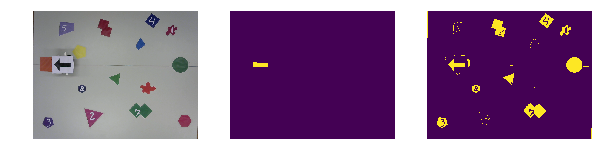

angle 179.0415529605138
arrow angle 179.6804844012982
object angle 179.0415529605138
turn_angle IN ANGLE -0.638931440784404
go_distance IN ANGLE 14.380514445523842


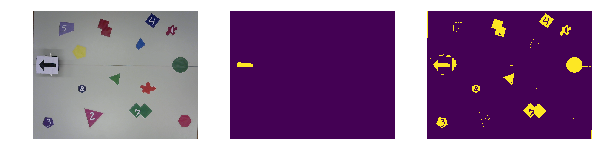

angle 50.861206590473905
turn_angle IN DISTANCE -126.00444175940586
go_distance IN DISTANCE 0.7137464301847942
Reached objects:  8
We realise  4
Destination object_location (301, 133)


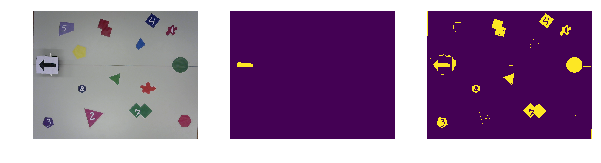

angle 62.54413859796827


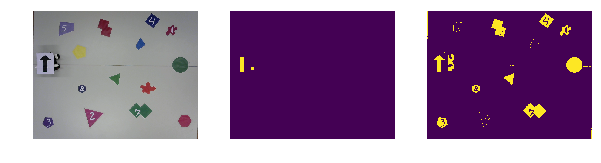

angle 59.21250842121787
arrow angle 89.9766526587593
object angle 59.21250842121787
turn_angle IN ANGLE -30.764144237541416
go_distance IN ANGLE 39.156648872125196


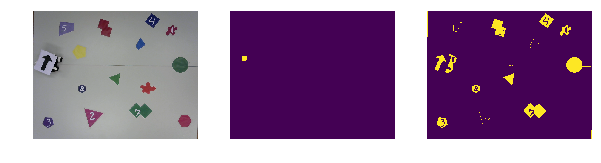

angle 59.44584159958367
arrow angle 65.6632633243758
object angle 59.44584159958367
turn_angle IN ANGLE -6.217421724792132
go_distance IN ANGLE 38.07823569058935


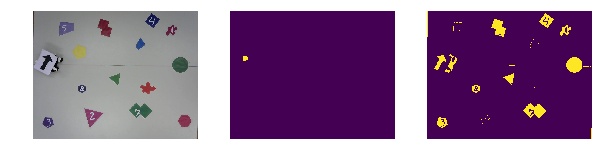

angle 59.527951125015434
arrow angle 61.529688826895644
object angle 59.527951125015434
turn_angle IN ANGLE -2.001737701880188
go_distance IN ANGLE 37.86326523922915


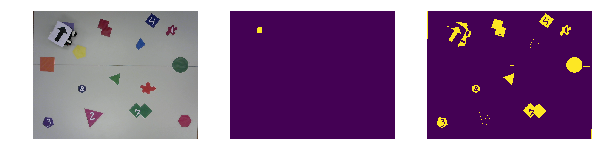

angle 45.9951451547188
turn_angle IN DISTANCE -12.569691104129447
go_distance IN DISTANCE 7.343279544422571


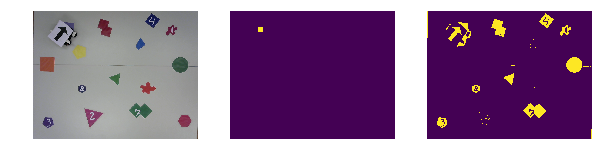

angle 44.97624522447474
arrow angle 51.83073396566205
object angle 44.97624522447474
turn_angle IN ANGLE -6.8544887411873106
go_distance IN ANGLE 6.770007544531208


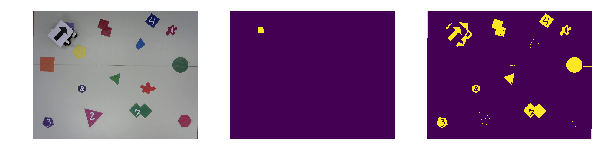

angle 45.536031078475226
arrow angle 47.85872956375621
object angle 45.536031078475226
turn_angle IN ANGLE -2.3226984852809665
go_distance IN ANGLE 6.6513302022430665


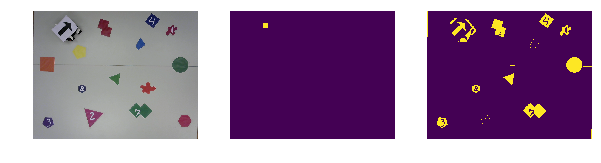

angle 12.168831178359033
turn_angle IN DISTANCE -31.216120222664586
go_distance IN DISTANCE 0.5475918103194473
Reached objects:  9
We took  5
Destination object_location (846, 254)


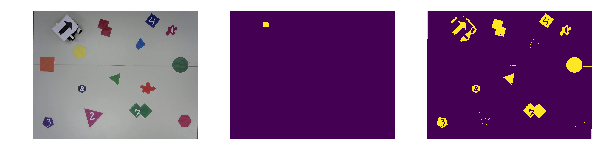

angle -12.95261098844325


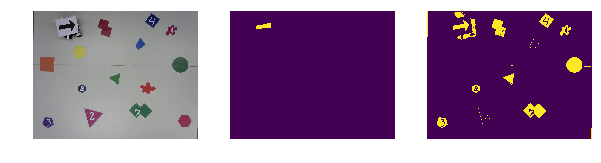

angle -14.326163418019094
arrow angle 11.237682539212944
object angle -14.326163418019094
turn_angle IN ANGLE -25.563845957232047
go_distance IN ANGLE 72.07569540149491


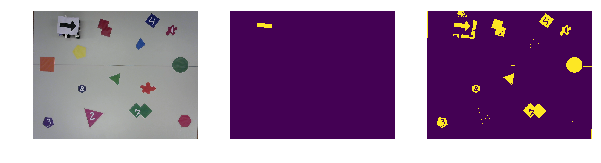

angle -14.843100580588322
arrow angle -6.242355547447687
object angle -14.843100580588322
turn_angle IN ANGLE -8.60074503314064
go_distance IN ANGLE 71.442530156268


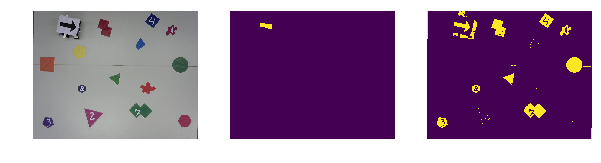

angle -14.821627374170312
arrow angle -13.28309810689035
object angle -14.821627374170312
turn_angle IN ANGLE -1.538529267279955
go_distance IN ANGLE 71.31869237607646


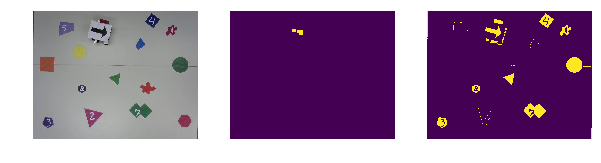

angle -18.27142830115766
turn_angle IN DISTANCE -3.651612448273454
go_distance IN DISTANCE 40.611636433482815


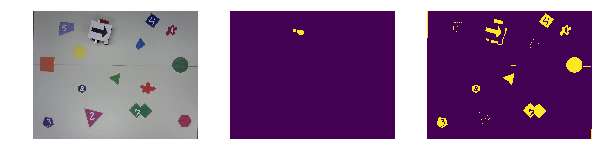

angle -18.307899653274763
arrow angle -14.44929198921011
object angle -18.307899653274763
turn_angle IN ANGLE -3.858607664064664
go_distance IN ANGLE 40.41011210660543


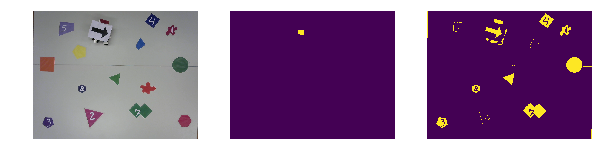

angle -18.34628645097393
arrow angle -17.482689952074452
object angle -18.34628645097393
turn_angle IN ANGLE -0.8635964988994829
go_distance IN ANGLE 40.25751697134102


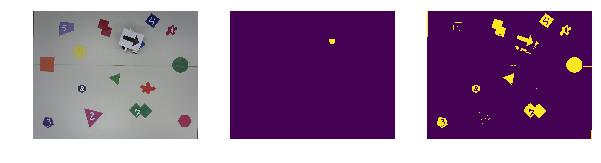

angle -28.501208634468952
turn_angle IN DISTANCE -8.859370181639747
go_distance IN DISTANCE 9.299844258757343


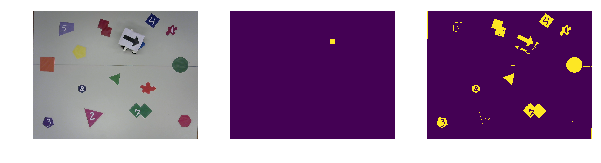

angle -28.51325511404052
arrow angle -24.45707807039139
object angle -28.51325511404052
turn_angle IN ANGLE -4.056177043649143
go_distance IN ANGLE 9.081766132882645


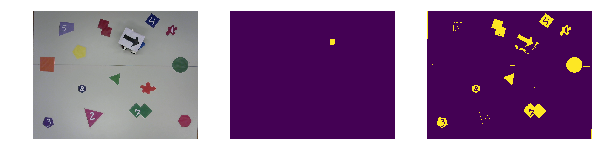

angle -28.73959759596344
arrow angle -27.310335561464285
object angle -28.73959759596344
turn_angle IN ANGLE -1.4292620344991747
go_distance IN ANGLE 9.046742334936521


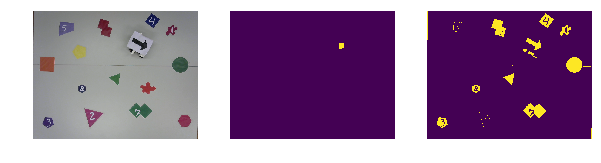

angle -115.83836422472699
turn_angle IN DISTANCE -86.79111585051095
go_distance IN DISTANCE 0.7449528685906199
Reached objects:  10
We realise  5
Destination object_location (849, 743)


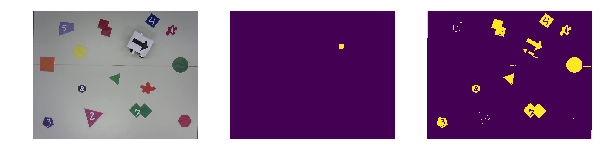

angle -90.26228429873584


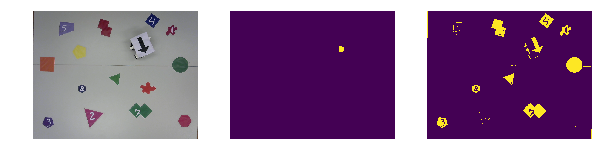

angle -91.80933864238699
arrow angle -67.34822078306411
object angle -91.80933864238699
turn_angle IN ANGLE -24.461117859322883
go_distance IN ANGLE 63.13317918540228


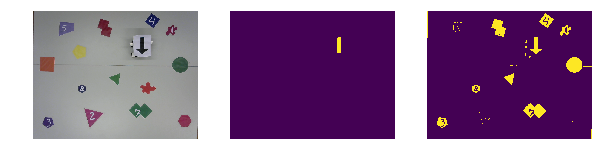

angle -91.52975243455836
arrow angle -90.13971492531925
object angle -91.52975243455836
turn_angle IN ANGLE -1.3900375092391073
go_distance IN ANGLE 62.42332079612638


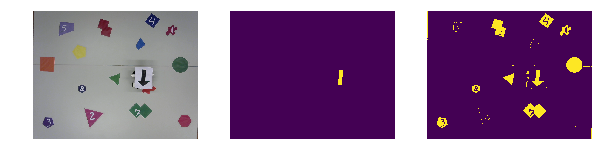

angle -95.1959147162868
turn_angle IN DISTANCE -2.5946164651643358
go_distance IN DISTANCE 31.43791269680272


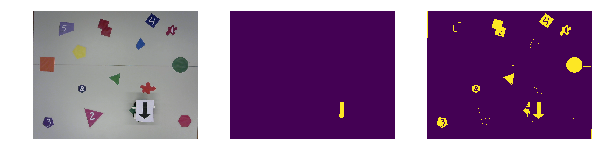

angle 173.96297943907052
turn_angle IN DISTANCE -94.41398974404638
go_distance IN DISTANCE 3.995139513057269
Reached objects:  11
We took  7
Destination object_location (587, 133)


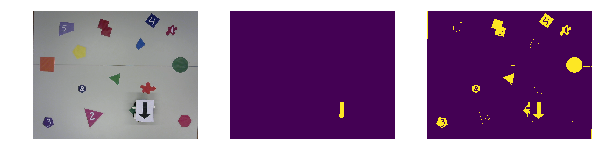

angle 115.48682743065207


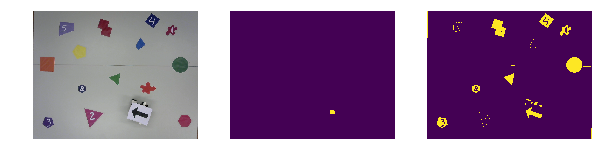

angle 111.79381091192158
arrow angle 159.54131427556266
object angle 111.79381091192158
turn_angle IN ANGLE -47.747503363641044
go_distance IN ANGLE 89.02656905465832


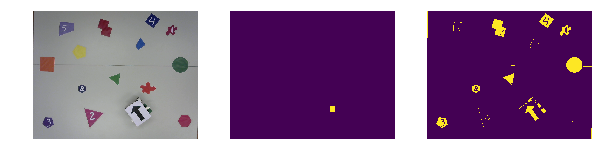

angle 111.23007633398366
arrow angle 125.3535641289582
object angle 111.23007633398366
turn_angle IN ANGLE -14.123487794974551
go_distance IN ANGLE 87.68900416351508


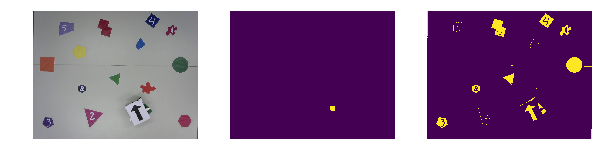

angle 111.11545673382358
arrow angle 116.36157940416376
object angle 111.11545673382358
turn_angle IN ANGLE -5.246122670340185
go_distance IN ANGLE 87.10776511721895


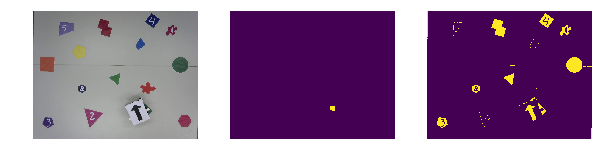

angle 111.11719069604239
arrow angle 112.90916092565476
object angle 111.11719069604239
turn_angle IN ANGLE -1.7919702296123887
go_distance IN ANGLE 86.99371602405621


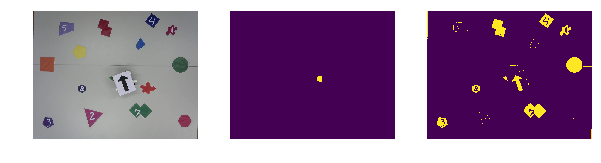

angle 109.35315584958842
turn_angle IN DISTANCE -0.5127085127746795
go_distance IN DISTANCE 55.9837243217045


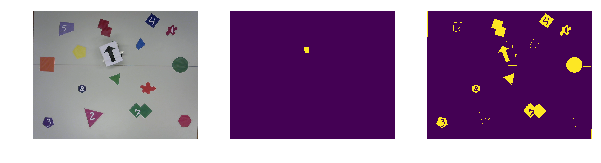

angle 103.04962375033239
turn_angle IN DISTANCE -7.050208213771953
go_distance IN DISTANCE 24.98816149599952


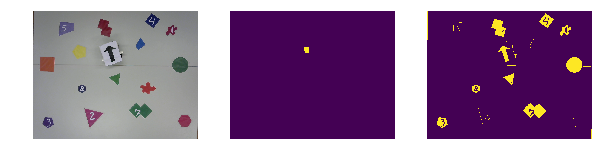

angle 102.84464361156549
arrow angle 107.61875872228919
object angle 102.84464361156549
turn_angle IN ANGLE -4.774115110723699
go_distance IN ANGLE 24.668159964366744


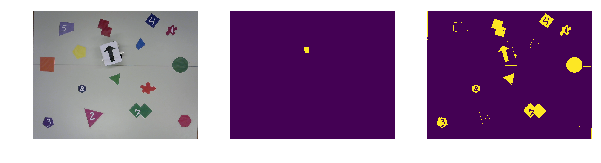

angle 102.86168624878434
arrow angle 105.38617576887702
object angle 102.86168624878434
turn_angle IN ANGLE -2.5244895200926862
go_distance IN ANGLE 24.66035041327857


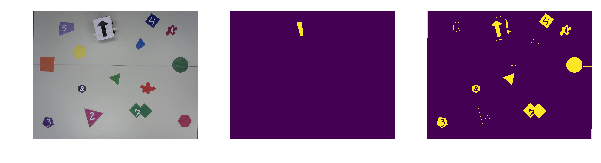

angle -6.4363929891068015
turn_angle IN DISTANCE -107.61983397227073
go_distance IN DISTANCE 1.474895433796478
Reached objects:  12
We realise  7
Destination object_location (419, 581)


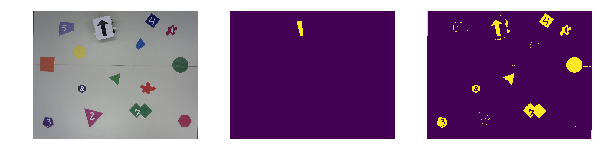

angle -108.92407302451875


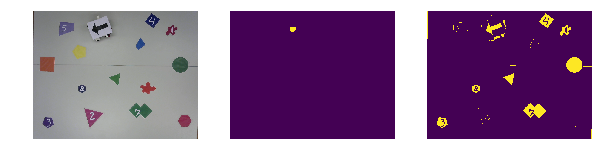

angle -105.73487574452332
arrow angle -159.6517805692731
object angle -105.73487574452332
turn_angle IN ANGLE 53.916904824749764
go_distance IN ANGLE 61.25121599707608


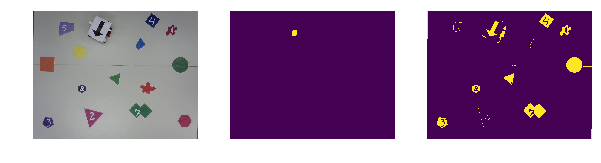

angle -105.99205575633576
arrow angle -116.14714529191949
object angle -105.99205575633576
turn_angle IN ANGLE 10.155089535583727
go_distance IN ANGLE 59.88484791384032


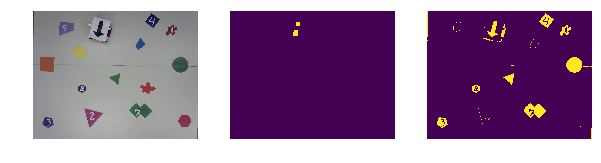

angle -106.25760958042719
arrow angle -105.48703720060834
object angle -106.25760958042719
turn_angle IN ANGLE -0.7705723798188728
go_distance IN ANGLE 59.637107603989854


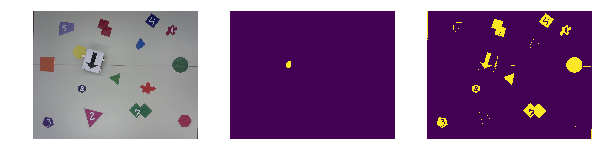

angle -111.24689357924774
turn_angle IN DISTANCE -5.4896371879016215
go_distance IN DISTANCE 28.639478226356985


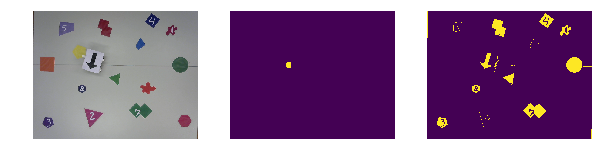

angle -111.33092380348921
arrow angle -106.79038021868925
object angle -111.33092380348921
turn_angle IN ANGLE -4.540543584799934
go_distance IN ANGLE 28.4391844573464


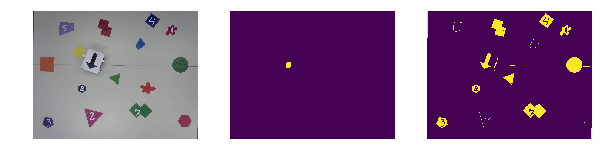

angle -111.18728155198396
arrow angle -111.14230941761357
object angle -111.18728155198396
turn_angle IN ANGLE -0.04497213437036862
go_distance IN ANGLE 28.3267958936008


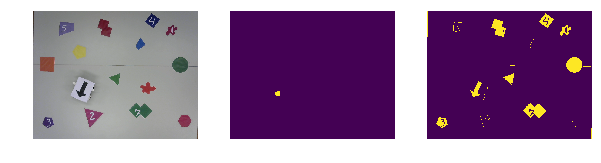

angle 110.68854536352502
turn_angle IN DISTANCE -135.32177996088643
go_distance IN DISTANCE 1.2214309824531973
Reached objects:  13
We took  8
Destination object_location (1173, 817)


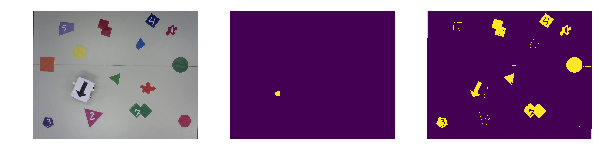

angle -16.838702462413647


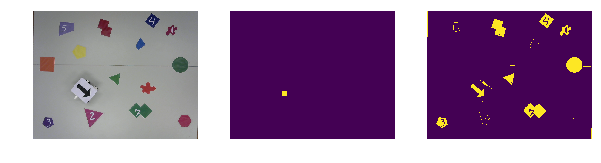

angle -16.676904379726746
arrow angle -41.15308633326845
object angle -16.676904379726746
turn_angle IN ANGLE 24.4761819535417
go_distance IN ANGLE 100.89247052968092


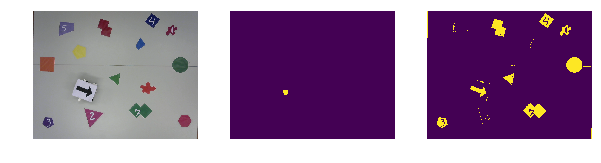

angle -16.88827840745403
arrow angle -20.98336991550042
object angle -16.88827840745403
turn_angle IN ANGLE 4.095091508046387
go_distance IN ANGLE 100.36551293630835


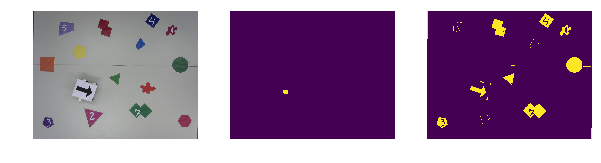

angle -16.916068039636812
arrow angle -18.89910681464187
object angle -16.916068039636812
turn_angle IN ANGLE 1.9830387750050562
go_distance IN ANGLE 100.42281633367429


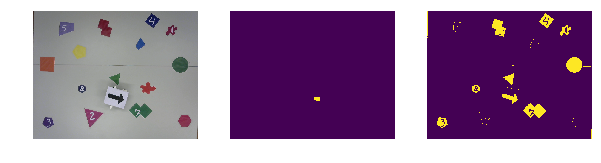

angle -18.757320944951253
turn_angle IN DISTANCE -1.9274226079142522
go_distance IN DISTANCE 69.29039331171919


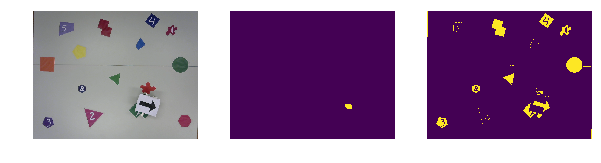

angle -23.205464808863525
turn_angle IN DISTANCE -5.70660158895771
go_distance IN DISTANCE 38.169908694877


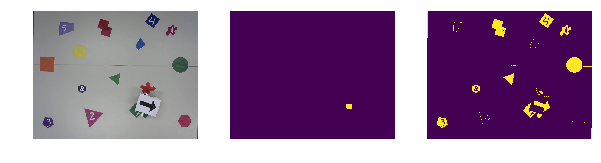

angle -23.277363103530575
arrow angle -18.95926589275524
object angle -23.277363103530575
turn_angle IN ANGLE -4.318097210775363
go_distance IN ANGLE 37.94662880172354


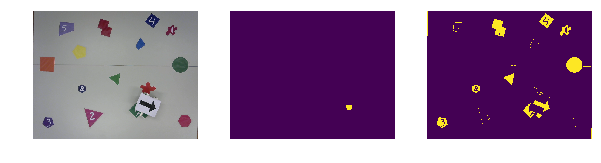

angle -23.085836403957998
arrow angle 66.6043497555103
object angle -23.085836403957998
turn_angle IN ANGLE -89.69018615946828
go_distance IN ANGLE 38.00085473892231


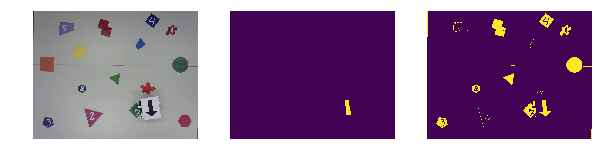

angle -19.794862263793316
arrow angle -81.24788433106386
object angle -19.794862263793316
turn_angle IN ANGLE 61.45302206727054
go_distance IN ANGLE 34.54502731132588


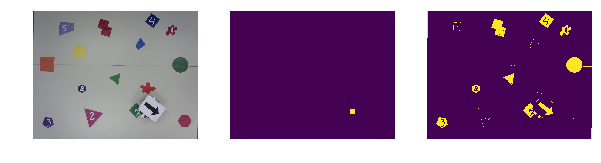

angle -20.163193818856364
arrow angle -38.36866782193363
object angle -20.163193818856364
turn_angle IN ANGLE 18.205474003077263
go_distance IN ANGLE 33.249802190237226


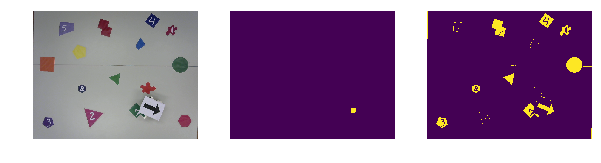

angle -20.932389964464388
arrow angle -24.119142814892143
object angle -20.932389964464388
turn_angle IN ANGLE 3.186752850427755
go_distance IN ANGLE 33.17130712429933


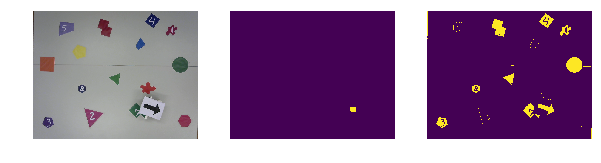

angle -21.25521023767233
arrow angle -20.477333347881824
object angle -21.25521023767233
turn_angle IN ANGLE -0.7778768897904911
go_distance IN ANGLE 33.127346688430414


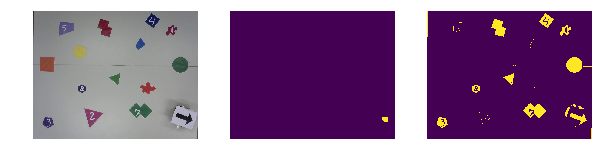

angle -95.29853906520093
turn_angle IN DISTANCE -75.57006777458395
go_distance IN DISTANCE 2.814070390561603
Reached objects:  14
We realise  8
Destination object_location [1140.1595092   407.17791411]


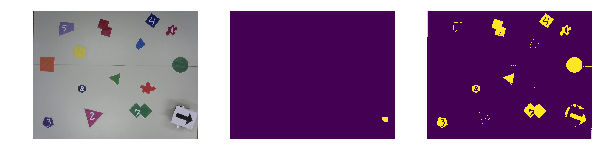

angle 95.12672012890783


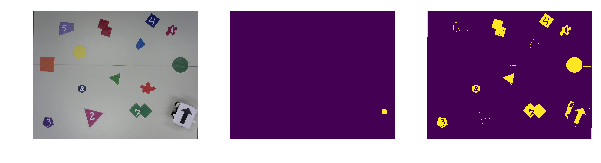

angle 95.91830363742413
arrow angle 66.10355113755604
object angle 95.91830363742413
turn_angle IN ANGLE 29.814752499868092
go_distance IN ANGLE 48.69307502637493


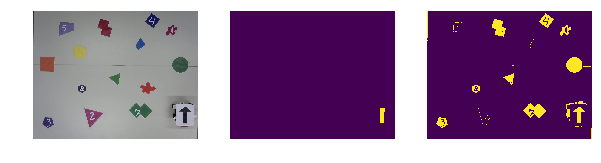

angle 95.81040714586318
arrow angle 89.63675581525598
object angle 95.81040714586318
turn_angle IN ANGLE 6.1736513306072
go_distance IN ANGLE 47.86288130665927


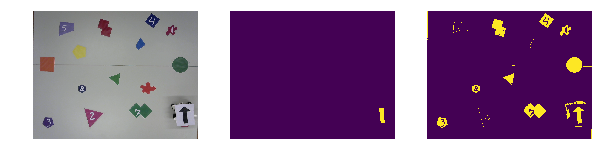

angle 95.65985427253575
arrow angle 94.4288765119251
object angle 95.65985427253575
turn_angle IN ANGLE 1.2309777606106564
go_distance IN ANGLE 47.858435823465555


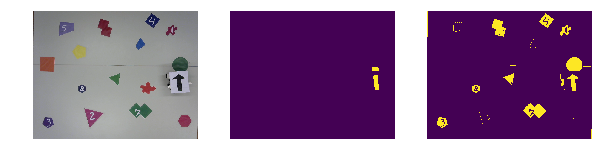

angle -100.50251049714312
turn_angle IN DISTANCE 75.47686044452912
go_distance IN DISTANCE 0.6798969448382939
Reached objects:  15
We took  Circle

 We finished


In [26]:
from iapr.robot import Robot

# Create Robot instance
robot = Robot(hostname='ev3dev.local')
# Beep
robot.beep(count=1)

# take_shapes_modif(ordered_digit, ordered_location, turn_thresh = 3, go_thresh = 15, black_thresh=70)
take_shapes_modif(ordered_digit, ordered_location, turn_thresh = 3, go_thresh = 5, black_thresh=70)
